In [ ]:
from google.colab import drive
drive.mount('/content/drive')
print('Done')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Done


In [ ]:
# Ignore this if not using FAMD
# pip install prince


In [ ]:
pip install optuna

In [ ]:
# Import training data for exploration
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
import os
import re
# import prince
import copy
from IPython.display import display
from sklearn.feature_selection import SelectKBest, chi2
import optuna
import logging

In [ ]:
base_path = '/content/drive/MyDrive/6740_Team66_Project'
train_file_path = os.path.join(base_path, 'training.csv')
test_file_path = os.path.join(base_path, 'test.csv')
# Load the training data
train_data = pd.read_csv(train_file_path)
test_data = pd.read_csv(test_file_path)

train_data.head()
# train_data["DiagPeriodL90D"].value_counts()
train_data.columns
# train_data['breast_cancer_diagnosis_desc'].value_counts()

Index(['patient_id', 'patient_race', 'payer_type', 'patient_state',
       'patient_zip3', 'patient_age', 'patient_gender', 'bmi',
       'breast_cancer_diagnosis_code', 'breast_cancer_diagnosis_desc',
       'metastatic_cancer_diagnosis_code', 'metastatic_first_novel_treatment',
       'metastatic_first_novel_treatment_type', 'Region', 'Division',
       'population', 'density', 'age_median', 'age_under_10', 'age_10_to_19',
       'age_20s', 'age_30s', 'age_40s', 'age_50s', 'age_60s', 'age_70s',
       'age_over_80', 'male', 'female', 'married', 'divorced', 'never_married',
       'widowed', 'family_size', 'family_dual_income',
       'income_household_median', 'income_household_under_5',
       'income_household_5_to_10', 'income_household_10_to_15',
       'income_household_15_to_20', 'income_household_20_to_25',
       'income_household_25_to_35', 'income_household_35_to_50',
       'income_household_50_to_75', 'income_household_75_to_100',
       'income_household_100_to_150', 'in

In [ ]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_colwidth', None)

## 1. Missing value analysis

In [ ]:
train_data.duplicated().sum() # 0 duplicates
train_data.isna().any()

# Check for missing values in the dataset
missing_values = train_data.isnull().sum()
# missing_values
missing_percentage = train_data.isnull().mean() * 100

# Create a summary table of missing values
missing_summary = pd.DataFrame({
    'Missing Values': missing_values,
    'Percentage Missing': missing_percentage
    }).sort_values(by='Percentage Missing', ascending=False)

missing_summary[missing_summary['Missing Values'] > 0].iloc[:10,]

,Missing Values,Percentage Missing
metastatic_first_novel_treatment,12882,99.814040
metastatic_first_novel_treatment_type,12882,99.814040
bmi,8965,69.463815
patient_race,6385,49.473113
payer_type,1803,13.970246
Region,52,0.402913
Division,52,0.402913
patient_state,51,0.395165
N02,29,0.224702
PM25,29,0.224702


## 2. Data statistics

In [ ]:
train_data['patient_state'].value_counts()

,count
patient_state,
CA,2438
TX,1155
NY,1041
MI,858
IL,782
OH,754
FL,609
GA,551
PA,483


In [ ]:
train_data['breast_cancer_diagnosis_code'].describe() # 50 breast cancer diagnosis codes
train_data['breast_cancer_diagnosis_code'].value_counts()
train_data['metastatic_cancer_diagnosis_code'].describe() # 43 metastatic cancer diagnosis codes

,metastatic_cancer_diagnosis_code
count,12906
unique,43
top,C773
freq,7052


In [ ]:
# Summary for numerical features
train_data.describe()

,patient_id,patient_zip3,patient_age,bmi,population,density,age_median,age_under_10,age_10_to_19,age_20s,age_30s,age_40s,age_50s,age_60s,age_70s,age_over_80,male,female,married,divorced,never_married,widowed,family_size,family_dual_income,income_household_median,income_household_under_5,income_household_5_to_10,income_household_10_to_15,income_household_15_to_20,income_household_20_to_25,income_household_25_to_35,income_household_35_to_50,income_household_50_to_75,income_household_75_to_100,income_household_100_to_150,income_household_150_over,income_household_six_figure,income_individual_median,home_ownership,housing_units,home_value,rent_median,rent_burden,education_less_highschool,education_highschool,education_some_college,education_bachelors,education_graduate,education_college_or_above,education_stem_degree,labor_force_participation,unemployment_rate,self_employed,farmer,race_white,race_black,race_asian,race_native,race_pacific,race_other,race_multiple,hispanic,disabled,poverty,limited_english,commute_time,health_uninsured,veteran,Ozone,PM25,N02,DiagPeriodL90D
count,12906.000000,12906.000000,12906.000000,3941.000000,12905.000000,12905.000000,12905.000000,12905.000000,12905.000000,12905.000000,12905.000000,12905.000000,12905.000000,12905.000000,12905.000000,12905.000000,12905.000000,12905.000000,12905.000000,12905.000000,12905.000000,12905.000000,12902.000000,12902.000000,12902.000000,12902.000000,12902.000000,12902.000000,12902.000000,12902.000000,12902.000000,12902.000000,12902.000000,12902.000000,12902.000000,12902.000000,12902.000000,12905.000000,12902.000000,12905.000000,1.290200e+04,12902.000000,12902.000000,12905.000000,12905.000000,12905.000000,12905.000000,12905.000000,12905.000000,12905.000000,12905.000000,12905.000000,12902.000000,12902.000000,12905.000000,12905.000000,12905.000000,12905.000000,12905.000000,12905.000000,12905.000000,12905.000000,12905.000000,12902.000000,12902.000000,12905.000000,12905.000000,12905.000000,12877.000000,12877.000000,12877.000000,12906.000000
mean,547381.196033,573.754300,59.183326,28.984539,20744.441237,1581.950419,40.502259,11.122784,12.945265,13.290376,12.862036,12.066978,13.441936,12.620903,7.653389,3.996221,50.095180,49.904900,47.680767,12.670532,33.834497,5.813387,3.202241,51.848542,74374.366908,3.269565,2.514251,4.142938,3.929804,4.071951,8.401565,11.561127,16.892327,12.664050,15.827931,16.723986,32.551917,36520.522622,65.994359,7575.709216,3.398172e+05,1237.303024,31.337751,11.989616,27.556060,28.924532,19.273300,12.257566,31.530866,43.385130,61.619846,5.952955,13.214106,1.861784,69.718255,11.447491,5.470315,0.900217,0.139318,5.682117,6.641799,18.459019,13.335299,13.406950,4.474956,27.978387,8.575284,7.083376,39.822352,7.475221,16.098988,0.624516
std,260404.959974,275.447534,13.335216,5.696906,13886.903756,2966.305306,4.036963,1.512376,1.923974,3.354103,2.324922,1.248499,1.643221,2.571528,2.147138,1.236823,1.656640,1.656594,7.491146,2.047935,8.019483,1.537171,0.224519,6.807659,20712.590100,1.448217,1.341073,1.767872,1.445416,1.345323,2.209765,2.577412,2.719725,1.831453,3.175040,8.940311,11.128674,8195.162293,14.117453,4916.905130,2.516976e+05,427.836972,4.775799,5.143849,7.992479,4.890567,6.173655,5.939814,11.632189,4.636082,5.945359,1.947654,3.411691,3.056104,17.960882,12.532624,6.735789,2.499784,0.505940,6.252393,3.544494,17.030894,3.690949,5.222495,4.837085,5.083939,4.203482,3.109022,3.559492,1.516499,5.842501,0.484266
min,100063.000000,101.000000,18.000000,14.000000,635.545455,0.916667,20.600000,0.000000,6.314286,5.925000,1.500000,0.800000,0.000000,0.200000,0.000000,0.000000,39.725000,38.400000,0.900000,0.200000,13.440000,0.000000,2.550370,19.312121,29222.000000,0.750000,0.361538,1.015385,1.027778,1.100000,2.650000,1.700000,4.950000,4.733333,4.288889,0.840000,5.692593,4316.000000,15.850000,0.000000,6.062900e+04,448.400000,17.415789,0.000000,0.000000,7.200000,2.465714,2.094118,7.048837,23.914706,30.700000,0.823077,2.262963,0.000000,14.495652,0.060976,0.000000,0.000000,0

In [ ]:
# Summary for categorical features
train_data.describe(include=['object', 'category'])

,patient_race,payer_type,patient_state,patient_gender,breast_cancer_diagnosis_code,breast_cancer_diagnosis_desc,metastatic_cancer_diagnosis_code,metastatic_first_novel_treatment,metastatic_first_novel_treatment_type,Region,Division
count,6521,11103,12855,12906,12906,12906,12906,24,24,12854,12854
unique,5,3,50,1,50,50,43,2,1,4,9
top,White,COMMERCIAL,CA,F,1749,"Malignant neoplasm of breast (female), unspecified",C773,PEMBROLIZUMAB,Antineoplastics,South,East North Central
freq,3588,6032,2438,12906,1982,1982,7052,13,24,3919,2923


In [ ]:
# # Inspect numerical columns for outliers

# # KDE for age column
# sns.kdeplot(train_data['patient_age'])
# plt.title('Distribution of Patient Age')
# plt.xlabel('Age')
# plt.ylabel('Density')
# plt.show()

# # Extract data with response within 90 days = 1
# train_data_l90 = train_data[train_data['DiagPeriodL90D'] == 1]
# sns.kdeplot(train_data_l90['patient_age'], label = 'DiagPeriod_within_90_days')

# # Extract data with response within 90 days = 0
# train_data_g90 = train_data[train_data['DiagPeriodL90D'] == 0]
# sns.kdeplot(train_data_g90['patient_age'], label = 'DiagPeriod_longer_than_90_days')
# plt.legend()

In [ ]:
# Delete columns
drop_cols = ['patient_race',
             'patient_gender',
             'bmi',
             'breast_cancer_diagnosis_code',
             'metastatic_first_novel_treatment',
             'metastatic_first_novel_treatment_type']
train = train_data.drop(columns = drop_cols)


## Impute NA values

In [ ]:
# Check na values by row
train[train.isna().sum(axis=1)>=2]

state_na = train['patient_state'].isna()

# Impute patient_state, Rregion, Division by patient_zip3
train['patient_state'] = train['patient_state'].fillna(train.groupby('patient_zip3')['patient_state'].transform(lambda x: x.mode()[0]))
train['Region'] = train['Region'].fillna(train.groupby('patient_zip3')['Region'].transform(lambda x: x.mode()[0]))
train['Division'] = train['Division'].fillna(train.groupby('patient_zip3')['Division'].transform(lambda x: x.mode()[0]))

# # Check if all the na values are filled
# train[state_na]



In [ ]:
(train.isna().sum(axis=1)>3).sum()/train.shape[0]*100 # in percent

0.07748334108166745

In [ ]:
# Remove rows where there are too many data missing
train = train.dropna(subset=['family_size']).reset_index(drop=True)
# train_impute[train_impute.isna().sum(axis=1)>=2]

# Impute empty 'payer_type' with 'UNKNOWN' if necessary
train.loc[train['payer_type'].isna(), 'payer_type'] = 'UNKNOWN'
# Imputation for numerical data (median)
env_num_cols = ['Ozone','PM25','N02']
num_imputer = SimpleImputer(strategy="median")
train.loc[:,env_num_cols] = num_imputer.fit_transform(train[env_num_cols])

# # Create environmental variable
# train.loc[:,'OzoneNo2PM25'] = train['Ozone'] * train['N02'] * train['PM25']

In [ ]:
# select features that are more representative
train_feat_select_col = ['patient_id', 'payer_type', 'patient_state', 'patient_zip3',
       'patient_age', 'breast_cancer_diagnosis_desc','metastatic_cancer_diagnosis_code',
                         'Region', 'Division','unemployment_rate','income_household_median','disabled','limited_english','health_uninsured','Ozone', 'PM25', 'N02', 'DiagPeriodL90D']
train = train[train_feat_select_col]

## NLP

In [ ]:
# # Select rows with 'male breast' in the 'breast_cancer_diagnosis_desc'
# male_rows = train_data[train_data['breast_cancer_diagnosis_desc'].str.contains(' male breast', case=False)]

# male_rows

In [ ]:
# # 'breast_cancer_diagnosis_desc' containing 'Malig neoplasm'
# Malig_num = (train['breast_cancer_diagnosis_desc'].str.contains('Malig neoplasm', case=False)).sum()
# print(f'Number of rows containing "Malig neoplasm": {Malig_num}')

# # 'breast_cancer_diagnosis_desc' containing 'Malignant neoplasm'
# Malignant_num = (train['breast_cancer_diagnosis_desc'].str.contains('Malignant neoplasm', case=False)).sum()
# print(f'Number of rows containing "Malignant neoplasm": {Malignant_num}')

# # 'breast_cancer_diagnosis_desc' containing 'Malig neoplm'
# Malig_neoplm_num = (train['breast_cancer_diagnosis_desc'].str.contains('Malig neoplm', case=False)).sum()
# print(f'Number of rows containing "Malig neoplm": {Malig_neoplm_num}')

# (Malig_num + Malig_neoplm_num + Malignant_num)/train.shape[0]*100

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
nltk.download('punkt_tab')
stop_words = set(stopwords.words('english'))
train['processed_description'] = train['breast_cancer_diagnosis_desc'].apply(lambda x: ' '.join(word for word in x.lower().split() if word not in stop_words))



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [ ]:
word_mapping = {
    "malig": "malignant",
    "neoplm": "neoplasm",
    "unsp": "unspecified",
    "ovrlp": "overlapping",
    'breast (female)': 'female breast',
    'sites':'site'
}

def replace_fn(text):
    return ' '.join(word_mapping.get(wd,wd) for wd in text.split())

def custom_tokenizer(text):
    # Regular expression to match words and hyphenated phrases
    return re.findall(r'\b\w+(?:-\w+)*\b', text)

preprocessed_vec= [" ".join(custom_tokenizer(doc)) for doc in train['processed_description']]
replaced_vec = [replace_fn(doc) for doc in preprocessed_vec]
# replaced_vec


https://www.ambrygen.com/material/oncology/icd-10-code-reference-sheets/breast-cancer-icd-10-codes/630

In [ ]:
# create breast cancer specific phrases
custom_vocab = ['malignant neoplasm', 'female breast', 'axillary tail',
                'unspecified site','overlapping sites','central portion',
                'nipple and areola']

# Initialize vectorizer to extract standard terms
vectorizer = TfidfVectorizer(tokenizer=custom_tokenizer,ngram_range=(1,1))
# vectorizer.fit(preprocessed_vec)
vectorizer.fit(replaced_vec)

# Get automatically generated vocabulary
standard_vocab = vectorizer.get_feature_names_out()

print("Standard Vocabulary:", standard_vocab)

# Merge with standard vocab dictionary and custom dictionary
merged_vocab = list(set(standard_vocab) | set(custom_vocab))
print("Merged Vocabulary:", merged_vocab)




Standard Vocabulary: ['areola' 'axillary' 'breast' 'central' 'female' 'left' 'lower-inner'
 'lower-outer' 'male' 'malignant' 'neoplasm' 'nipple' 'overlapping'
 'portion' 'quadrant' 'right' 'secondary' 'site' 'specified' 'tail'
 'unspecified' 'upper-inner' 'upper-outer']
Merged Vocabulary: ['central', 'areola', 'right', 'breast', 'female', 'lower-inner', 'specified', 'neoplasm', 'quadrant', 'tail', 'left', 'lower-outer', 'unspecified site', 'female breast', 'upper-inner', 'male', 'secondary', 'nipple and areola', 'overlapping', 'unspecified', 'malignant neoplasm', 'central portion', 'axillary', 'overlapping sites', 'malignant', 'nipple', 'site', 'upper-outer', 'portion', 'axillary tail']


/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [ ]:
# created a custom vocabulary dictionary containing specific words
vocab_cust = ['lower-outer', 'upper-outer', 'upper-inner', 'lower-inner',
              'central portion', 'nipple and areola', 'unspecified', 'right',
              'left', 'overlapping', 'female breast',  'axillary tail',
              'secondary',
              # 'site', 'female', 'malignant neoplasm', 'areola', 'quadrant',
              'male_breast'
              ]
vectorizer = TfidfVectorizer(tokenizer=custom_tokenizer, vocabulary=vocab_cust,ngram_range=(1,2))

# Fit and transform the documents
tfidf_matrix = vectorizer.fit_transform(replaced_vec)

# Get feature names (tokens)
feature_names = vectorizer.get_feature_names_out()
feature_names

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


array(['lower-outer', 'upper-outer', 'upper-inner', 'lower-inner',
       'central portion', 'nipple and areola', 'unspecified', 'right',
       'left', 'overlapping', 'female breast', 'axillary tail',
       'secondary', 'male_breast'], dtype=object)

In [ ]:

# Select 10 features with highest chi-squared statistics
chi2_selector = SelectKBest(chi2, k=10)
chi2_selector.fit(tfidf_matrix,train['DiagPeriodL90D'])

# Look at scores returned from the selector for each feature
chi2_scores = pd.DataFrame(list(zip(feature_names, chi2_selector.scores_, chi2_selector.pvalues_)),
                                       columns=['ftr', 'score', 'pval']).sort_values(by='score', ascending=False)
# chi2_scores.head(10)
chi2_scores[chi2_scores['pval'] <= 0.05]

,ftr,score,pval
7,right,298.274332,7.829605e-67
8,left,267.250256,4.510400e-60
6,unspecified,221.439550,4.389203e-50
9,overlapping,117.447953,2.290320e-27
10,female breast,68.726398,1.131166e-16
3,lower-inner,11.824415,5.845909e-04
12,secondary,10.122247,1.464903e-03
1,upper-outer,4.494086,3.401229e-02


In [ ]:
# Tf-idf
tfidf_train_df = pd.DataFrame(tfidf_matrix.toarray(), columns="bc_desc_"+feature_names)
tfidf_train_filtered_df = tfidf_train_df.loc[:,"bc_desc_"+np.array(chi2_scores['ftr'][:10])]
train.drop(columns = ['breast_cancer_diagnosis_desc','processed_description'], inplace = True)
train = pd.concat([train, tfidf_train_filtered_df], axis=1)

In [ ]:
train.head()

,patient_id,payer_type,patient_state,patient_zip3,patient_age,metastatic_cancer_diagnosis_code,Region,Division,unemployment_rate,income_household_median,disabled,limited_english,health_uninsured,Ozone,PM25,N02,DiagPeriodL90D,bc_desc_right,bc_desc_left,bc_desc_unspecified,bc_desc_overlapping,bc_desc_female breast,bc_desc_lower-inner,bc_desc_secondary,bc_desc_upper-outer,bc_desc_lower-outer,bc_desc_upper-inner
0,475714,MEDICAID,CA,924,84,C7989,West,Pacific,8.471429,52996.28571,12.871429,10.100000,11.200000,52.237210,8.650555,18.606528,1,0.000000,0.000000,0.937976,0.0,0.346699,0.0,0.0,0.000000,0.0,0.000000
1,349367,COMMERCIAL,CA,928,62,C773,West,Pacific,5.103030,102741.63640,8.957576,8.057576,7.018182,42.301121,8.487175,20.113179,1,0.580471,0.000000,0.000000,0.0,0.322410,0.0,0.0,0.747734,0.0,0.000000
2,138632,COMMERCIAL,TX,760,43,C773,South,West South Central,4.560000,85984.74138,11.253333,3.356667,15.066667,40.108207,7.642753,14.839351,1,0.000000,0.445492,0.000000,0.0,0.240350,0.0,0.0,0.000000,0.0,0.000000
3,617843,COMMERCIAL,CA,926,45,C773,West,Pacific,5.264286,120533.83330,8.845238,5.280952,4.404762,42.070075,7.229393,15.894123,0,0.000000,0.467853,0.000000,0.0,0.252414,0.0,0.0,0.000000,0.0,0.846995
4,817482,COMMERCIAL,ID,836,55,C773,West,Mountain,4.258000,61075.13043,15.276000,1.946000,12.088000,41.356058,4.110749,11.722197,0,0.000000,0.000000,1.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000


## Further analysis

In [ ]:
na1 = train.isna().sum(axis=1)==1
train[na1]

train['payer_type'].value_counts()

,count
payer_type,
COMMERCIAL,6030
MEDICAID,2567
MEDICARE ADVANTAGE,2502
UNKNOWN,1803


In [ ]:
region_division_table = pd.crosstab(train['Region'], train['Division'])

# Display the table
region_division_table

Division,East North Central,East South Central,Middle Atlantic,Mountain,New England,Pacific,South Atlantic,West North Central,West South Central
Region,,,,,,,,,
Midwest,2926,0,0,0,0,0,0,730,0
Northeast,0,0,1557,0,5,0,0,0,0
South,0,498,0,0,0,0,1982,0,1450
West,0,0,0,984,0,2770,0,0,0


<Axes: xlabel='Region', ylabel='Count'>

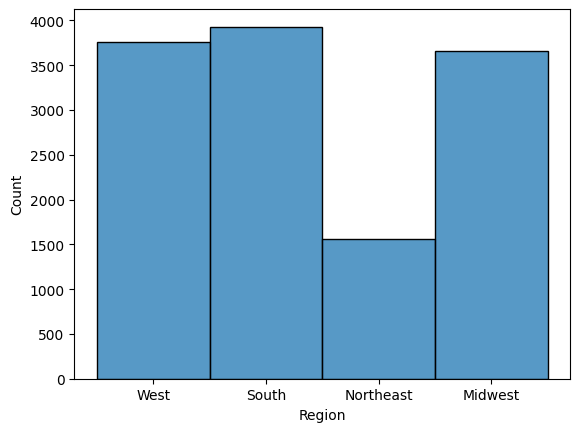

In [ ]:
sns.histplot(train['Region'])

([0, 1, 2, 3, 4, 5, 6, 7, 8],
 [Text(0, 0, 'Pacific'),
  Text(1, 0, 'West South Central'),
  Text(2, 0, 'Mountain'),
  Text(3, 0, 'Middle Atlantic'),
  Text(4, 0, 'East North Central'),
  Text(5, 0, 'East South Central'),
  Text(6, 0, 'South Atlantic'),
  Text(7, 0, 'West North Central'),
  Text(8, 0, 'New England')])

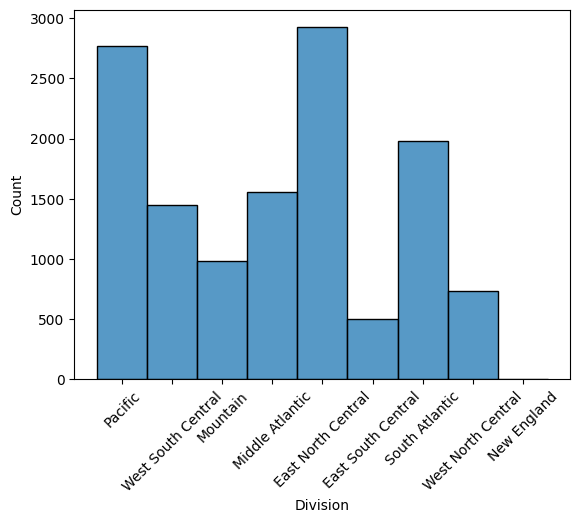

In [ ]:
sns.histplot(train['Division'])
plt.xticks(rotation=45)

## Subset CA data for exploration

In [ ]:
# Extract CA data for exploration
CA_data = train[train['patient_state'] == 'CA']
CA_data.drop(columns = ['patient_id', 'patient_state'], inplace = True)
# CA_data.drop(columns = ['breast_cancer_diagnosis_code', 'breast_cancer_diagnosis_desc','processed_description'], inplace = True)

<ipython-input-176-4a643b4e6f87>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  CA_data.drop(columns = ['patient_id', 'patient_state'], inplace = True)


In [ ]:
CA_data.head()

,payer_type,patient_zip3,patient_age,metastatic_cancer_diagnosis_code,Region,Division,unemployment_rate,income_household_median,disabled,limited_english,health_uninsured,Ozone,N02,DiagPeriodL90D,bc_desc_right,bc_desc_left,bc_desc_site,bc_desc_unspecified,bc_desc_overlapping,bc_desc_female breast,bc_desc_female,bc_desc_malignant neoplasm,bc_desc_areola,bc_desc_nipple
0,MEDICAID,924,84,C7989,West,Pacific,8.471429,52996.28571,12.871429,10.100000,11.200000,52.237210,18.606528,1,0.000000,0.000000,0.423812,0.783886,0.0,0.289743,0.247118,0.246755,0.0,0.0
1,COMMERCIAL,928,62,C773,West,Pacific,5.103030,102741.63640,8.957576,8.057576,7.018182,42.301121,20.113179,1,0.470314,0.000000,0.000000,0.000000,0.0,0.261226,0.222796,0.222468,0.0,0.0
3,COMMERCIAL,926,45,C773,West,Pacific,5.264286,120533.83330,8.845238,5.280952,4.404762,42.070075,15.894123,0,0.000000,0.407099,0.000000,0.000000,0.0,0.219636,0.187325,0.187049,0.0,0.0
6,COMMERCIAL,900,51,C779,West,Pacific,8.683077,69266.69355,11.901538,14.737500,10.341538,41.186992,21.644261,1,0.000000,0.590351,0.465880,0.430847,0.0,0.318503,0.271647,0.271248,0.0,0.0
11,MEDICARE ADVANTAGE,900,66,C7800,West,Pacific,8.683077,69266.69355,11.901538,14.737500,10.341538,41.186992,21.644261,0,0.000000,0.000000,0.000000,0.746626,0.0,0.000000,0.470745,0.470052,0.0,0.0


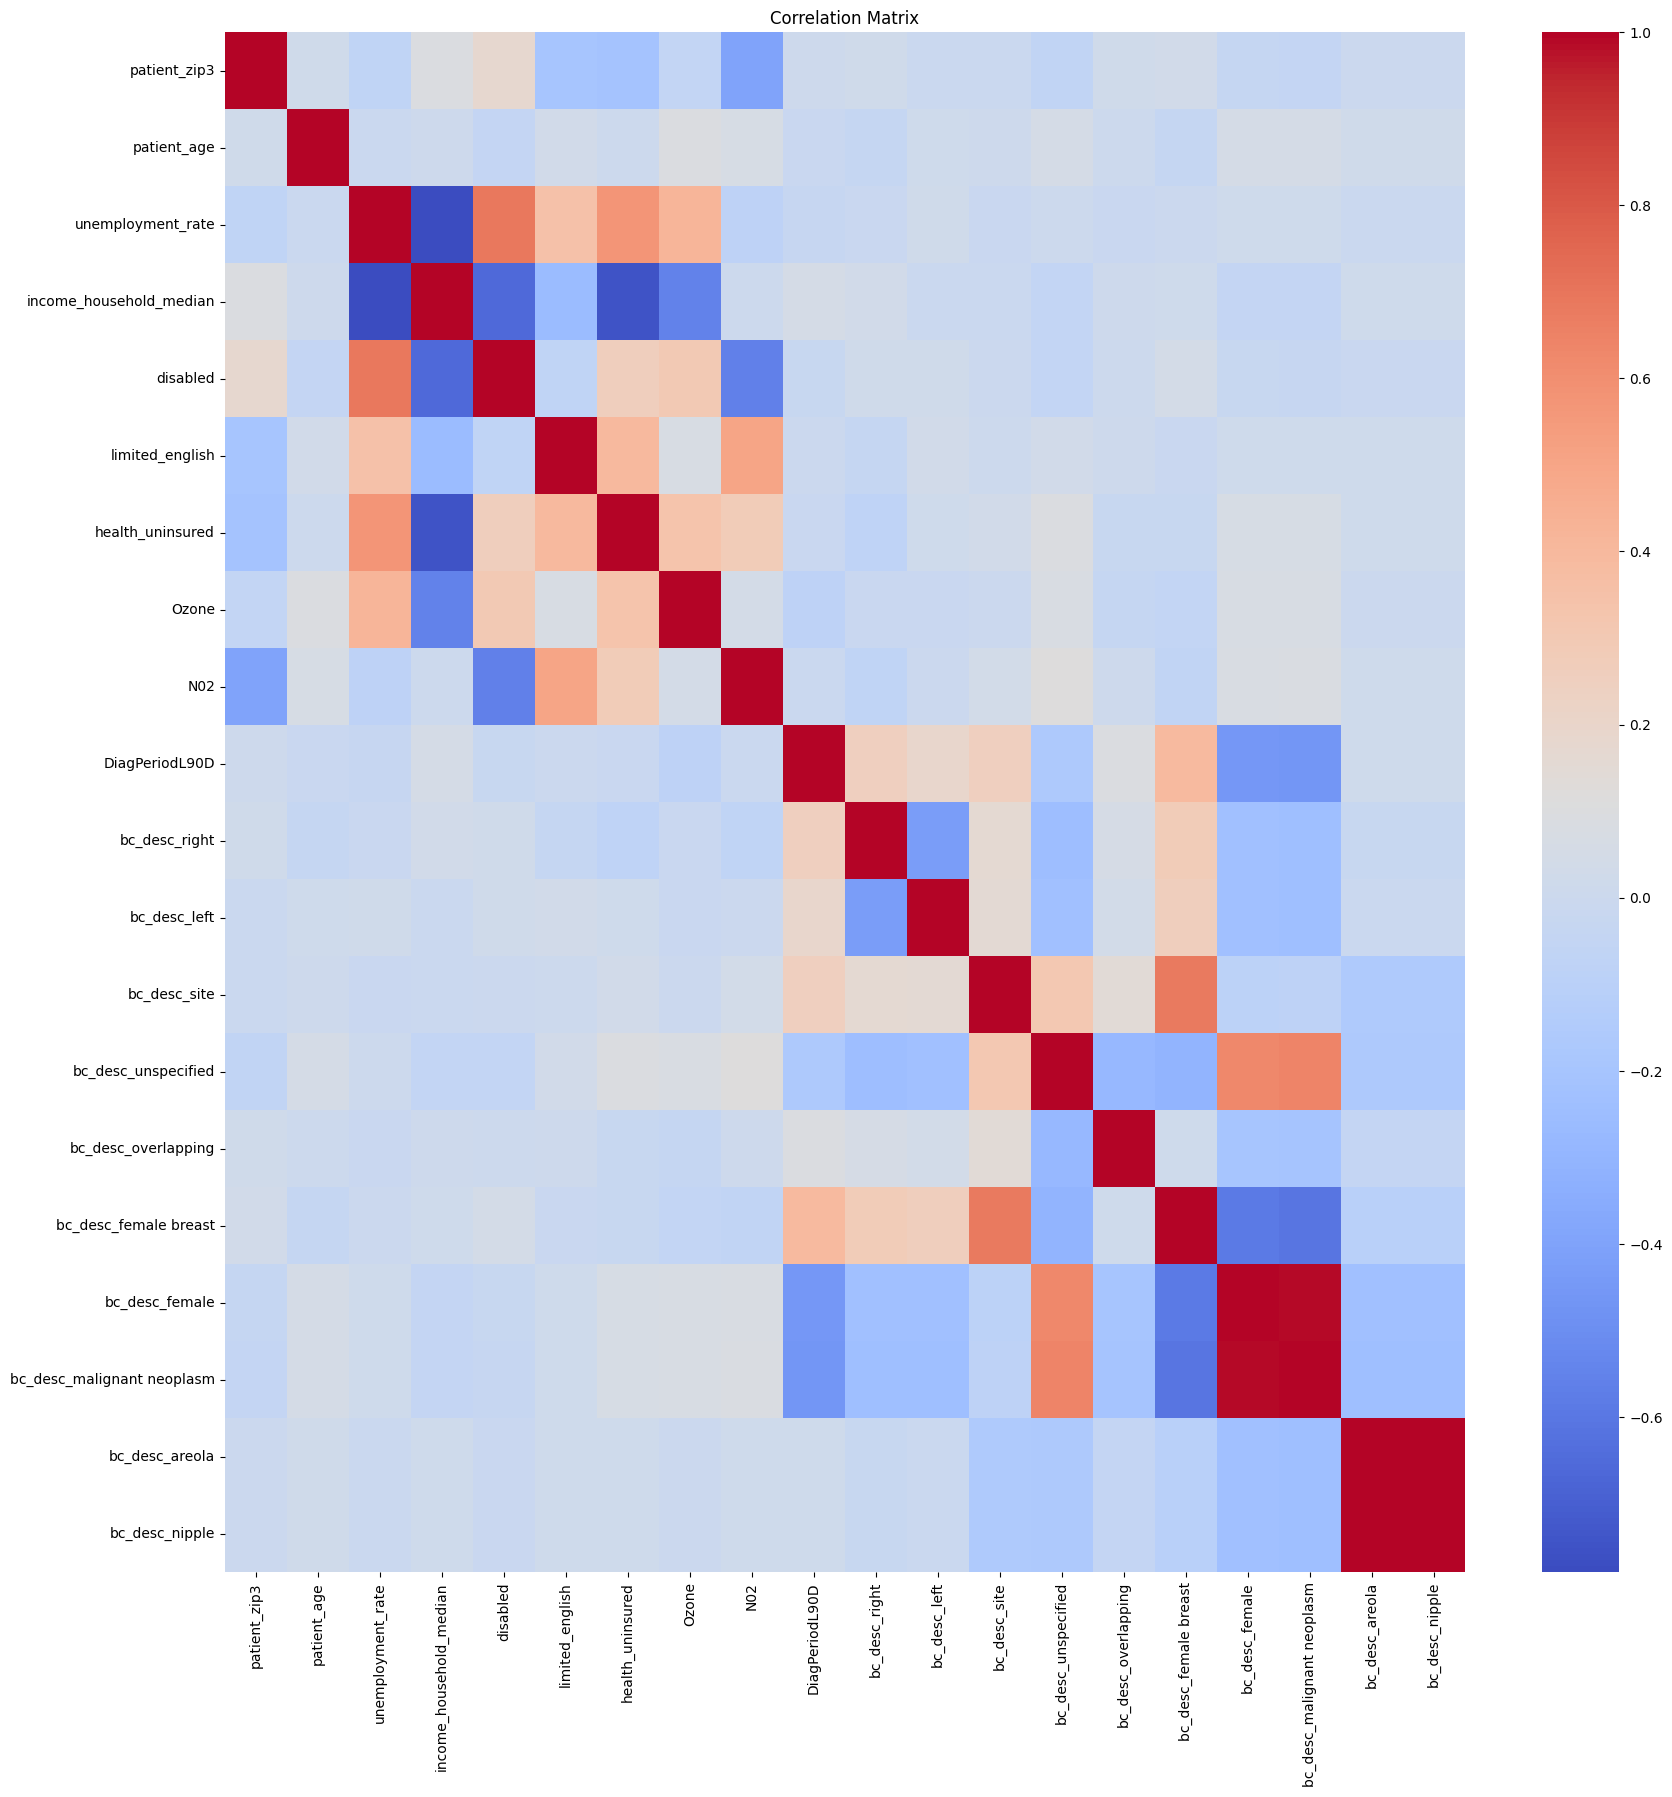

In [ ]:
# Extract numerical features
numerical_features = CA_data.select_dtypes(include=[np.number])

# Calculate the correlation of the numerical features
correlation = numerical_features.corr()
correlation.shape

# Plot the correlation matrix
plt.figure(figsize=(20, 20))
sns.heatmap(correlation, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()





In [ ]:
# Impute empty 'payer_type' with 'UNKNOWN' if necessary
CA_data.loc[CA_data['payer_type'].isna(), 'payer_type'] = 'UNKNOWN'
CA_data['payer_type'].value_counts()

,count
payer_type,
COMMERCIAL,1019
MEDICAID,635
UNKNOWN,415
MEDICARE ADVANTAGE,378


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

# To convert the categorical data to features
CA_data_dummy = pd.get_dummies(CA_data, drop_first = True, dtype=float)

# To partition the data into predictors and response
X = CA_data_dummy.drop(columns = ['DiagPeriodL90D'])
y = CA_data_dummy['DiagPeriodL90D']

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=123)

# Build random forest classification
clf = RandomForestClassifier(random_state=123)
clf.fit(X_train, y_train)
clf.score(X_test, y_test)


0.7938775510204081

In [ ]:
CA_data_dummy

,patient_zip3,patient_age,unemployment_rate,income_household_median,disabled,limited_english,health_uninsured,Ozone,N02,DiagPeriodL90D,bc_desc_right,bc_desc_left,bc_desc_site,bc_desc_unspecified,bc_desc_overlapping,bc_desc_female breast,bc_desc_female,bc_desc_malignant neoplasm,bc_desc_areola,bc_desc_nipple,payer_type_MEDICAID,payer_type_MEDICARE ADVANTAGE,payer_type_UNKNOWN,metastatic_cancer_diagnosis_code_C771,metastatic_cancer_diagnosis_code_C772,metastatic_cancer_diagnosis_code_C773,metastatic_cancer_diagnosis_code_C775,metastatic_cancer_diagnosis_code_C778,metastatic_cancer_diagnosis_code_C779,metastatic_cancer_diagnosis_code_C7800,metastatic_cancer_diagnosis_code_C7801,metastatic_cancer_diagnosis_code_C7802,metastatic_cancer_diagnosis_code_C781,metastatic_cancer_diagnosis_code_C782,metastatic_cancer_diagnosis_code_C7839,metastatic_cancer_diagnosis_code_C785,metastatic_cancer_diagnosis_code_C786,metastatic_cancer_diagnosis_code_C787,metastatic_cancer_diagnosis_code_C7880,metastatic_cancer_diagnosis_code_C7889,metastatic_cancer_diagnosis_code_C7900,metastatic_cancer_diagnosis_code_C7911,metastatic_cancer_diagnosis_code_C792,metastatic_cancer_diagnosis_code_C7931,metastatic_cancer_diagnosis_code_C7932,metastatic_cancer_diagnosis_code_C7940,metastatic_cancer_diagnosis_code_C7949,metastatic_cancer_diagnosis_code_C7951,metastatic_cancer_diagnosis_code_C7952,metastatic_cancer_diagnosis_code_C7960,metastatic_cancer_diagnosis_code_C7970,metastatic_cancer_diagnosis_code_C7981,metastatic_cancer_diagnosis_code_C7982,metastatic_cancer_diagnosis_code_C7989,metastatic_cancer_diagnosis_code_C799
0,924,84,8.471429,52996.28571,12.871429,10.100000,11.200000,52.237210,18.606528,1,0.000000,0.000000,0.423812,0.783886,0.0,0.289743,0.247118,0.246755,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,928,62,5.103030,102741.63640,8.957576,8.057576,7.018182,42.301121,20.113179,1,0.470314,0.000000,0.000000,0.000000,0.0,0.261226,0.222796,0.222468,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,926,45,5.264286,120533.83330,8.845238,5.280952,4.404762,42.070075,15.894123,0,0.000000,0.407099,0.000000,0.000000,0.0,0.219636,0.187325,0.187049,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,900,51,8.683077,69266.69355,11.901538,14.737500,10.341538,41.186992,21.644261,1,0.000000,0.590351,0.465880,0.430847,0.0,0.318503,0.271647,0.271248,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11,900,66,8.683077,69266.69355,11.901538,14.737500,10.341538,41.186992,21.644261,0,0.000000,0.000000,0.000000,0.746626,0.0,0.000000,0.470745,0.470052,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12883,952,35,10.457500,74622.37143,17.747500,5.853846,6.157500,42.985816,10.309493,1,0.000000,0.481012,0.000000,0.000000,0.0,0.259513,0.221335,0.221010,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12888,900,48,8.683077,69266.69355,11.901538,14.737500,10.341538,41.186992,21.644261,1,0.000000,0.590351,0.465880,0.430847,0.0,0.318503,0.271647,0.271248,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12894,920,58,5.509302,96525.68293,9.323810,3.747619,7.647619,43.583794,12.907401

              precision    recall  f1-score   support

           0       0.80      0.58      0.67       178
           1       0.79      0.92      0.85       312

    accuracy                           0.79       490
   macro avg       0.80      0.75      0.76       490
weighted avg       0.79      0.79      0.78       490



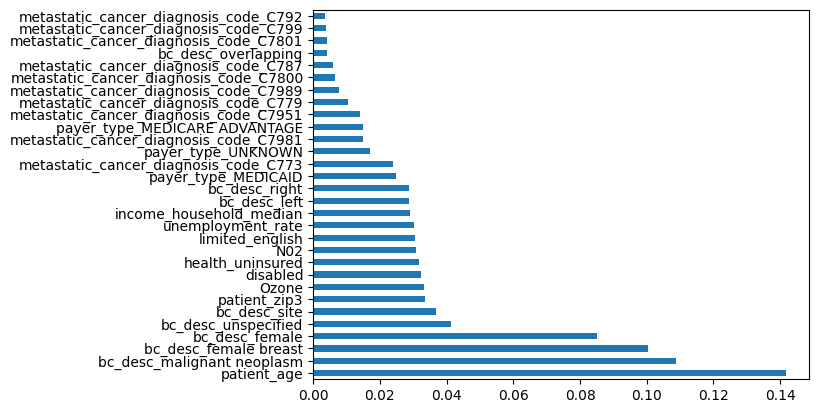

In [ ]:
# To see the importance of each feature
feature_importances = pd.DataFrame(clf.feature_importances_,
                                   index = X_train.columns,
                                    columns=['importance']).sort_values('importance', ascending=False)
feature_importances['importance'][:30].plot(kind='barh')

# Assess the model performance using classification report
from sklearn.metrics import classification_report

y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

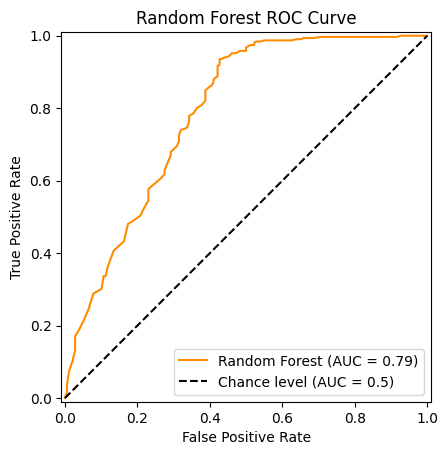

In [ ]:
y_pred_prob = clf.predict_proba(X_test)[:,1]

from sklearn.metrics import RocCurveDisplay
roc = RocCurveDisplay.from_predictions(
    y_test,
    y_pred_prob,
    name='Random Forest',
    color="darkorange",
    plot_chance_level=True,
)
_ = roc.ax_.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title="Random Forest ROC Curve",
)

In [ ]:
train_data.loc[train_data['breast_cancer_diagnosis_code'].isin(["1748", "1744", "1749"]) , 'DiagPeriodL90D'].value_counts()

,count
DiagPeriodL90D,
0,2431
1,247


In the newer ICD-10 system:
- "1749" would roughly translate to "C50.919" which also signifies a malignant neoplasm of unspecified site in the female breast. [(Conversion to ICD-10)](https://www.icd10data.com/Convert/174.9#:~:text=ICD%2D9%2DCM%20174.9%20converts,site%20of%20unspecified%20female%20breast)
- ICD-9-CM 174.4 converts approximately to: 2025 ICD-10-CM C50. 419 Malignant neoplasm of upper-outer quadrant of unspecified female breast.
- ICD-9-CM 174.8 converts approximately to: 2025 ICD-10-CM C50. 819 Malignant neoplasm of overlapping sites of unspecified female breast.

In [ ]:
# Factor analysis of mixed data
famd = prince.FAMD(
    n_components=10,
    n_iter=3,
    copy=True,
    check_input=True,
    random_state=42,
    engine="sklearn",
    handle_unknown="error"  # same parameter as sklearn.preprocessing.OneHotEncoder
    )
famd = famd.fit(CA_data.iloc[:,:-1])

In [ ]:
famd.eigenvalues_summary

,eigenvalue,% of variance,% of variance (cumulative)
component,,,
0,7.340,1.24%,1.24%
1,6.526,1.11%,2.35%
2,5.619,0.95%,3.30%
3,5.242,0.89%,4.19%
4,4.968,0.84%,5.03%
5,4.916,0.83%,5.87%
6,4.743,0.80%,6.67%
7,4.590,0.78%,7.45%
8,4.498,0.76%,8.21%


In [ ]:
famd.plot(
    CA_data.iloc[:,:-1],
    x_component=0,
    y_component=1
)

alt.LayerChart(...)

In [ ]:
# Converted dimensional reduction with top 10 eigenvectors
famd.row_coordinates(CA_data).head()

component,0,1,2,3,4,5,6,7,8,9
0,4.484094,0.818862,4.258635,1.051943,0.915244,-0.872953,-1.426250,1.541941,-0.143943,-2.339857
1,-2.219828,0.254845,-0.277843,0.427845,0.353856,0.798179,-3.563483,-1.003285,1.228917,-0.855089
3,-3.522673,-0.247044,-2.139163,0.902174,-1.429267,0.150933,0.773065,-0.737627,0.722291,1.172931
6,1.999706,0.796333,0.849278,-0.304561,-0.943983,0.083902,-1.001696,0.429332,0.286690,0.501978
11,6.434486,-3.870109,-0.621278,-0.811630,0.231092,0.056955,1.400609,-1.094473,-0.188502,0.460740


## Full Dataset - Retain **division**

In [ ]:
######################################## Try Division 12/13 ########################################

In [ ]:
train_impute = copy.deepcopy(train)

In [ ]:
train_division = copy.deepcopy(train_impute)
# train_division

In [ ]:
# Delete columns
train_division_1 = train_division.drop(columns = ['patient_id', 'patient_state', 'patient_zip3', 'Region'])
# train_division_1

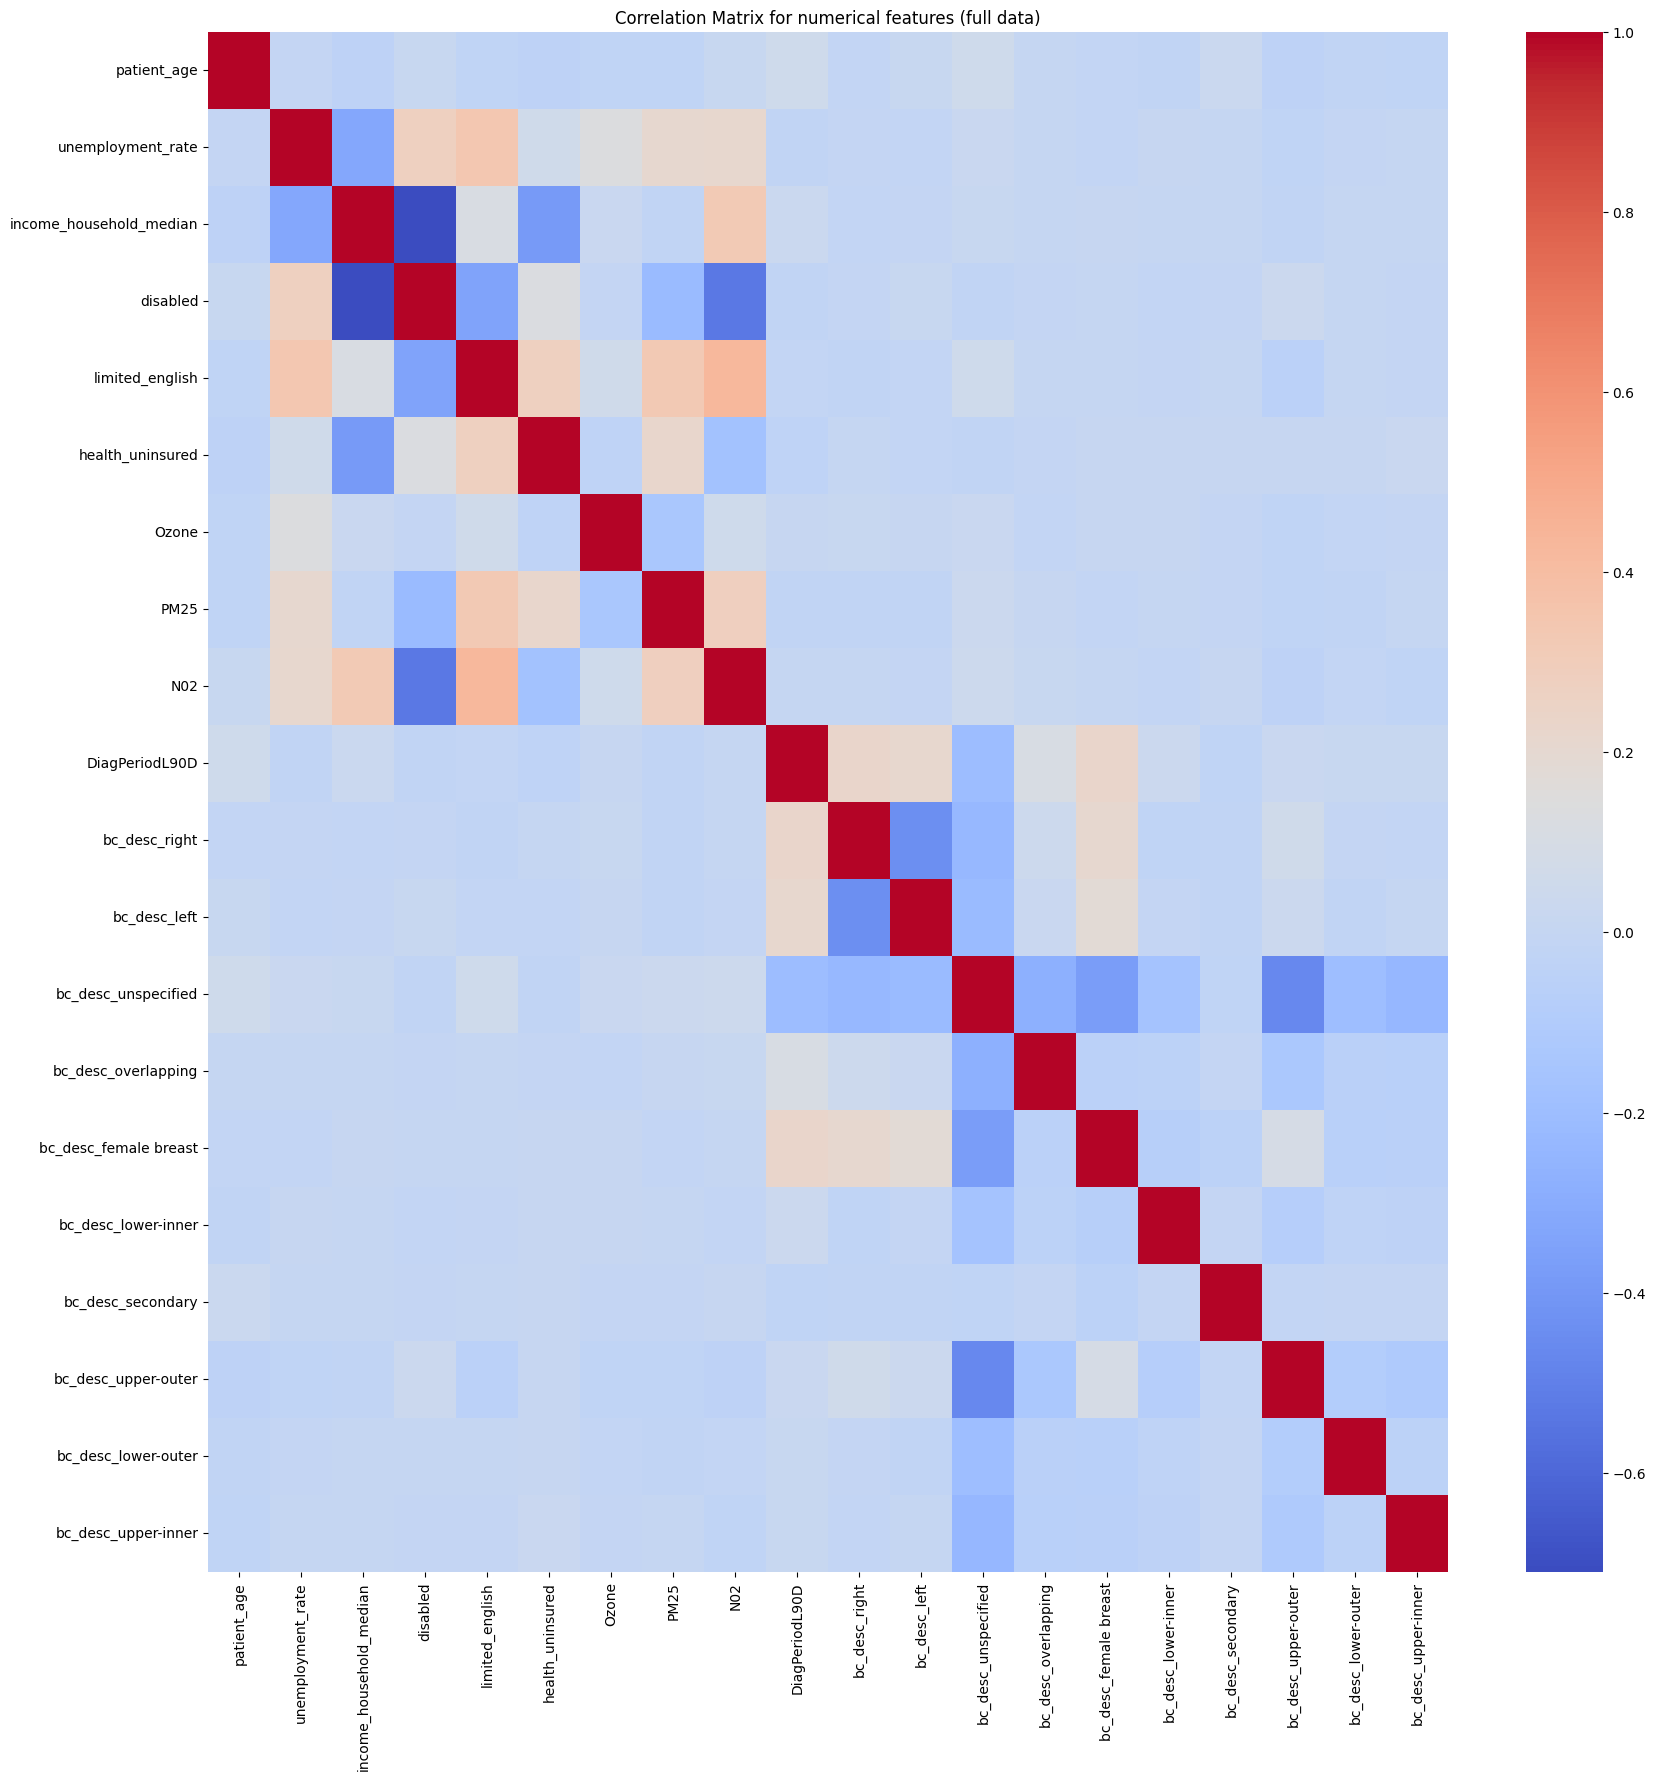

In [ ]:
# Extract numerical features
numerical_features_full = train_division_1.select_dtypes(include=[np.number])

# Calculate the correlation of the numerical features
correlation_full = numerical_features_full.corr()
correlation_full.shape

# Plot the correlation matrix
plt.figure(figsize=(20, 20))
sns.heatmap(correlation_full, cmap='coolwarm')
plt.title('Correlation Matrix for numerical features (full data)')
plt.show()

- Response variable has correlations with 'right', 'left', 'unspecified', 'overlapping','female breast'.
- 'unemployment rate', 'income_household_medium', 'disabled', 'limited english', 'health_uninsured','NO2', 'PM25','Ozone' are having correlations

In [ ]:
train_division_dummy = pd.get_dummies(train_division_1, drop_first = True, dtype=float)
# train_division_dummy

In [ ]:
######## feature engineering END #########

In [ ]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from lightgbm import LGBMClassifier

In [ ]:
X = train_division_dummy.drop(columns=['DiagPeriodL90D'])  # Features
y = train_division_dummy['DiagPeriodL90D']
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
feature_names = X_train.columns
feature_names

Index(['patient_age', 'unemployment_rate', 'income_household_median',
       'disabled', 'limited_english', 'health_uninsured', 'Ozone', 'PM25',
       'N02', 'bc_desc_right', 'bc_desc_left', 'bc_desc_unspecified',
       'bc_desc_overlapping', 'bc_desc_female breast', 'bc_desc_lower-inner',
       'bc_desc_secondary', 'bc_desc_upper-outer', 'bc_desc_lower-outer',
       'bc_desc_upper-inner', 'payer_type_MEDICAID',
       'payer_type_MEDICARE ADVANTAGE', 'payer_type_UNKNOWN',
       'metastatic_cancer_diagnosis_code_C771',
       'metastatic_cancer_diagnosis_code_C772',
       'metastatic_cancer_diagnosis_code_C773',
       'metastatic_cancer_diagnosis_code_C774',
       'metastatic_cancer_diagnosis_code_C775',
       'metastatic_cancer_diagnosis_code_C778',
       'metastatic_cancer_diagnosis_code_C779',
       'metastatic_cancer_diagnosis_code_C7800',
       'metastatic_cancer_diagnosis_code_C7801',
       'metastatic_cancer_diagnosis_code_C7802',
       'metastatic_cancer_diagnosis

In [ ]:
# Data transformation
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score, accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# Add Lasso and Ridge Logistic Regression
models = {
    "Lasso Logistic Regression": LogisticRegression(penalty='l1', solver='liblinear', max_iter=1000, random_state=42),
    "Ridge Logistic Regression": LogisticRegression(penalty='l2', solver='lbfgs', max_iter=1000, random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
    "AdaBoost": AdaBoostClassifier(random_state=42, algorithm='SAMME'),
    "LightGBM": LGBMClassifier(random_state=42),
    "Support Vector Machine": SVC(probability=True, random_state=42),
    "K-Nearest Neighbors": KNeighborsClassifier(),
    "Random Forest": RandomForestClassifier(random_state=42)
}

# Perform cross-validation and evaluate models
cv_results = {}
final_results = {}

# Standardize features for models sensitive to scaling
scaler = StandardScaler()

for name, model in models.items():
    print(f"Processing {name}...")

    # Create a pipeline for models requiring scaling
    if "Logistic Regression" in name or "SVM" in name or "K-Nearest Neighbors" in name:
        pipeline = Pipeline([
            ('scaler', scaler),
            ('model', model)
        ])
    else:
        pipeline = model

    # Cross-validation with ROC-AUC scoring
    cv_scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='roc_auc')
    mean_score = cv_scores.mean()
    std_score = cv_scores.std()
    cv_results[name] = {"Mean ROC-AUC": mean_score, "Std Dev": std_score}
    print(f"{name} - Mean ROC-AUC: {mean_score:.4f}, Std Dev: {std_score:.4f}")

    # Train the model on the training set
    pipeline.fit(X_train, y_train)

    # Predict on the test set
    if hasattr(pipeline, "predict_proba") or hasattr(pipeline.named_steps['model'], "predict_proba"):
        y_proba = pipeline.predict_proba(X_test)[:, 1]
        auc_score = roc_auc_score(y_test, y_proba)
    else:
        auc_score = "Not Available (no probabilities)"

    y_pred = pipeline.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)

    # Print classification report
    print(f"\nClassification Report for {name}:\n")
    print(classification_report(y_test, y_pred))

    # Store final evaluation metrics
    final_results[name] = {"Accuracy": accuracy, "ROC-AUC": auc_score}

# Summarize results
cv_results_df = pd.DataFrame(cv_results).T  # Cross-validation results
final_results_df = pd.DataFrame(final_results).T  # Test set results

print("\nCross-Validation Results:")
print(cv_results_df)

print("\nFinal Test Set Results:")
print(final_results_df)


Processing Lasso Logistic Regression...
Lasso Logistic Regression - Mean ROC-AUC: 0.7600, Std Dev: 0.0113

Classification Report for Lasso Logistic Regression:

              precision    recall  f1-score   support

           0       0.65      0.60      0.63       948
           1       0.78      0.81      0.80      1633

    accuracy                           0.74      2581
   macro avg       0.72      0.71      0.71      2581
weighted avg       0.73      0.74      0.73      2581

Processing Ridge Logistic Regression...
Ridge Logistic Regression - Mean ROC-AUC: 0.7599, Std Dev: 0.0113

Classification Report for Ridge Logistic Regression:

              precision    recall  f1-score   support

           0       0.65      0.60      0.63       948
           1       0.78      0.81      0.80      1633

    accuracy                           0.74      2581
   macro avg       0.72      0.71      0.71      2581
weighted avg       0.73      0.74      0.73      2581

Processing XGBoost...


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [20:59:12] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [20:59:12] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [20:59:12] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [20:59:13] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [20:59:13] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_e

XGBoost - Mean ROC-AUC: 0.7895, Std Dev: 0.0052


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [20:59:14] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Classification Report for XGBoost:

              precision    recall  f1-score   support

           0       0.80      0.59      0.68       948
           1       0.79      0.91      0.85      1633

    accuracy                           0.79      2581
   macro avg       0.80      0.75      0.76      2581
weighted avg       0.80      0.79      0.79      2581

Processing AdaBoost...
AdaBoost - Mean ROC-AUC: 0.7644, Std Dev: 0.0112

Classification Report for AdaBoost:

              precision    recall  f1-score   support

           0       0.89      0.50      0.64       948
           1       0.77      0.96      0.86      1633

    accuracy                           0.79      2581
   macro avg       0.83      0.73      0.75      2581
weighted avg       0.81      0.79      0.78      2581

Processing LightGBM...
[LightGBM] [Info] Number of positive: 5140, number of negative: 3116
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003220 seconds.
You

In [ ]:
final_results_df

,Accuracy,ROC-AUC
Lasso Logistic Regression,0.735761,0.761823
Ridge Logistic Regression,0.735761,0.761703
XGBoost,0.794653,0.787719
AdaBoost,0.793878,0.774999
LightGBM,0.802790,0.792060
Support Vector Machine,0.783417,0.780163
K-Nearest Neighbors,0.721813,0.717146
Random Forest,0.777218,0.770349


In [ ]:
cv_results_df

,Mean ROC-AUC,Std Dev
Lasso Logistic Regression,0.760022,0.011323
Ridge Logistic Regression,0.759850,0.011276
XGBoost,0.789485,0.005223
AdaBoost,0.764353,0.011247
LightGBM,0.796793,0.009777
Support Vector Machine,0.782191,0.012719
K-Nearest Neighbors,0.717503,0.011107
Random Forest,0.782584,0.009724


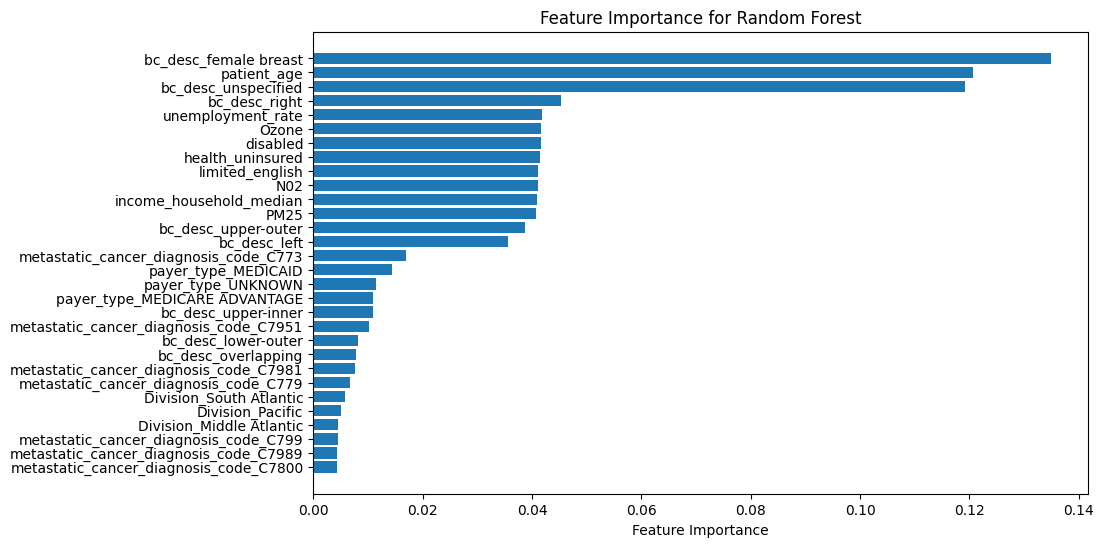

In [ ]:
import matplotlib.pyplot as plt

model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# Get feature importances
importances = model.feature_importances_

# Create a DataFrame for better visualization
importance_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": importances
}).sort_values(by="Importance", ascending=False)

importance_df = importance_df.head(30)

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.barh(importance_df["Feature"], importance_df["Importance"], align="center")
plt.gca().invert_yaxis()  # Invert y-axis to show the most important feature at the top
plt.xlabel("Feature Importance")
plt.title("Feature Importance for Random Forest")
plt.show()


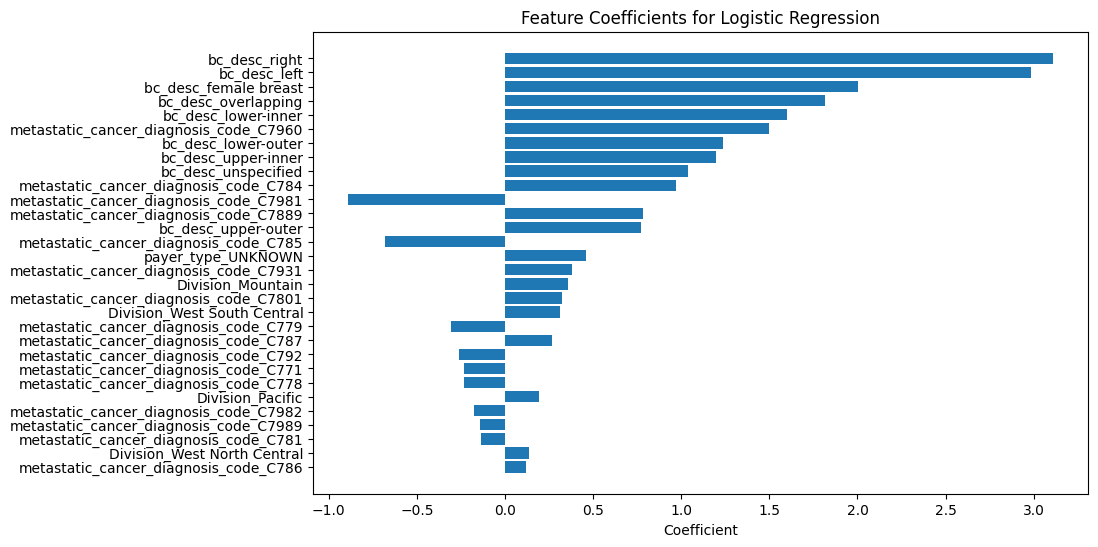

In [261]:
### Logistic regression coefficient -- feature importance
# Assuming you have already fitted a Logistic Regression model
logreg = LogisticRegression(penalty='l1', solver='liblinear', max_iter=1000, random_state=42)
logreg.fit(X_train, y_train)

# Get coefficients
coefficients = logreg.coef_[0]  # Logistic regression returns a 2D array for coefficients

# Create a DataFrame for better visualization
importance_df = pd.DataFrame({
    "Feature": feature_names,
    "Coefficient": coefficients
}).sort_values(by="Coefficient", key=abs, ascending=False)

importance_df = importance_df.head(30)
# importance_df
# Plot coefficients
plt.figure(figsize=(10, 6))
plt.barh(importance_df["Feature"], importance_df["Coefficient"], align="center")
plt.gca().invert_yaxis()  # Invert y-axis to show the most important feature at the top
plt.xlabel("Coefficient")
plt.title("Feature Coefficients for Logistic Regression")
plt.show()


In [ ]:
######################################## END ########################################

### Random forest: retaining **state** representing zip, region, and division

In [ ]:
# train_state = train_impute.drop(columns = ['patient_id',
#                                            'patient_zip3',
#                                            'Region',
#                                            'Division'])

# # To convert the categorical data to features
# state_dummy = pd.get_dummies(train_state, drop_first = True)

# # To slice the CA_data with and without 'DiagPeriodL90D' column
# X = state_dummy.drop(columns = ['DiagPeriodL90D'])
# y = state_dummy['DiagPeriodL90D']

# X_train, X_test, y_train, y_test = train_test_split(X,
#                                                     y,
#                                                     test_size=0.2,
#                                                     random_state=123)

# # Build random forest model
# clf = RandomForestClassifier(random_state=123)
# clf.fit(X_train, y_train)
# clf.score(X_test, y_test)

# # Output dataframe showing feature importance
# feature_importances = pd.DataFrame(clf.feature_importances_,
#                                    index = X_train.columns,
#                                     columns=['importance']).sort_values('importance', ascending=False)
# feature_importances['importance'][:10].plot(kind='barh')
# print(classification_report(y_test, clf.predict(X_test)))

# # ROC curve
# from sklearn.metrics import RocCurveDisplay
# display = RocCurveDisplay.from_predictions(
#     y_test,
#     clf.predict_proba(X_test)[:,1],
#     name='Random Forest',
#     color="darkorange",
#     plot_chance_level=True,
# )
# _ = display.ax_.set(
#     xlabel="False Positive Rate",
#     ylabel="True Positive Rate",
#     title="Random Forest ROC Curve",
# )

In [ ]:
# from sklearn.feature_selection import VarianceThreshold

# # Step 1: Define the threshold for variance
# # Common thresholds: 0.01 (1%), 0.05 (5%), or based on domain knowledge
# threshold = 0.01

# # Step 2: Initialize the VarianceThreshold object
# selector = VarianceThreshold(threshold=threshold)

# # Step 3: Fit and transform your feature matrix (X)
# X_reduced = selector.fit_transform(X)

# # Step 4: Get the retained features
# retained_features = X.columns[selector.get_support()]
# X_reduced_df = pd.DataFrame(X_reduced, columns=retained_features)

# # Print the retained features and their count
# print(f"Number of features retained: {len(retained_features)}")
# print(f"Retained features: {retained_features.tolist()}")

# X = X_reduced_df

# # Train-test split
# X_train, X_test, y_train, y_test = train_test_split(X, y,
#                                                     test_size=0.2,
#                                                     random_state=123)

# # Data transformation
# from sklearn.preprocessing import StandardScaler
# sc = StandardScaler()
# X_train = sc.fit_transform(X_train)
# X_test = sc.transform(X_test)

In [ ]:

# # Initialize models
# models = {
#     "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
#     "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
#     "AdaBoost": AdaBoostClassifier(random_state=42,algorithm='SAMME'),
#     "LightGBM": LGBMClassifier(random_state=42),
#     "Support Vector Machine": SVC(probability=True, random_state=42),
#     "K-Nearest Neighbors": KNeighborsClassifier(),
#     "Random Forest": RandomForestClassifier(random_state=42)
# }

# # Perform cross-validation and evaluate models
# cv_results = {}
# final_results = {}

# for name, model in models.items():
#     print(f"Processing {name}...")

#     # Cross-validation with ROC-AUC scoring
#     cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='roc_auc')
#     mean_score = cv_scores.mean()
#     std_score = cv_scores.std()
#     cv_results[name] = {"Mean ROC-AUC": mean_score, "Std Dev": std_score}
#     print(f"{name} - Mean ROC-AUC: {mean_score:.4f}, Std Dev: {std_score:.4f}")

#     # Train the model on the training set
#     model.fit(X_train, y_train)

#     # Predict on the test set
#     if hasattr(model, "predict_proba"):
#         y_proba = model.predict_proba(X_test)[:, 1]
#         auc_score = roc_auc_score(y_test, y_proba)
#     else:
#         auc_score = "Not Available (no probabilities)"

#     y_pred = model.predict(X_test)
#     accuracy = accuracy_score(y_test, y_pred)

#     # Print classification report
#     print(f"\nClassification Report for {name}:\n")
#     print(classification_report(y_test, y_pred))

#     # Store final evaluation metrics
#     final_results[name] = {"Accuracy": accuracy, "ROC-AUC": auc_score}

# # Summarize results
# cv_results_df = pd.DataFrame(cv_results).T  # Cross-validation results
# final_results_df = pd.DataFrame(final_results).T  # Test set results

# print("\nCross-Validation Results:")
# print(cv_results_df)

# print("\nFinal Test Set Results:")
# print(final_results_df)


## Environmental impact

In [ ]:
train_data.columns

Index(['patient_id', 'patient_race', 'payer_type', 'patient_state',
       'patient_zip3', 'patient_age', 'patient_gender', 'bmi',
       'breast_cancer_diagnosis_code', 'breast_cancer_diagnosis_desc',
       'metastatic_cancer_diagnosis_code', 'metastatic_first_novel_treatment',
       'metastatic_first_novel_treatment_type', 'Region', 'Division',
       'population', 'density', 'age_median', 'age_under_10', 'age_10_to_19',
       'age_20s', 'age_30s', 'age_40s', 'age_50s', 'age_60s', 'age_70s',
       'age_over_80', 'male', 'female', 'married', 'divorced', 'never_married',
       'widowed', 'family_size', 'family_dual_income',
       'income_household_median', 'income_household_under_5',
       'income_household_5_to_10', 'income_household_10_to_15',
       'income_household_15_to_20', 'income_household_20_to_25',
       'income_household_25_to_35', 'income_household_35_to_50',
       'income_household_50_to_75', 'income_household_75_to_100',
       'income_household_100_to_150', 'in

In [ ]:
# Seperate features by fact
patient_characteristics = ['patient_id',
                           'patient_race',
                           'payer_type',
                           'patient_state',
                           'patient_zip3',
                           'patient_age',
                           'patient_gender',
                           'bmi',]

diag_treat = ['breast_cancer_diagnosis_code',
              'breast_cancer_diagnosis_desc',
              'metastatic_cancer_diagnosis_code',
              'metastatic_first_novel_treatment',
              'metastatic_first_novel_treatment_type']

demographic = ['Region', 'Division',
       'population', 'density', 'age_median', 'age_under_10', 'age_10_to_19',
       'age_20s', 'age_30s', 'age_40s', 'age_50s', 'age_60s', 'age_70s',
       'age_over_80', 'male', 'female', 'married', 'divorced', 'never_married',
       'widowed', 'family_size', 'family_dual_income',
       'income_household_median', 'income_household_under_5',
       'income_household_5_to_10', 'income_household_10_to_15',
       'income_household_15_to_20', 'income_household_20_to_25',
       'income_household_25_to_35', 'income_household_35_to_50',
       'income_household_50_to_75', 'income_household_75_to_100',
       'income_household_100_to_150', 'income_household_150_over',
       'income_household_six_figure', 'income_individual_median',
       'home_ownership', 'housing_units', 'home_value', 'rent_median',
       'rent_burden', 'education_less_highschool', 'education_highschool',
       'education_some_college', 'education_bachelors', 'education_graduate',
       'education_college_or_above', 'education_stem_degree',
       'labor_force_participation', 'unemployment_rate', 'self_employed',
       'farmer', 'race_white', 'race_black', 'race_asian', 'race_native',
       'race_pacific', 'race_other', 'race_multiple', 'hispanic', 'disabled',
       'poverty', 'limited_english', 'commute_time', 'health_uninsured',
       'veteran']

environment = ['Ozone', 'PM25', 'N02']

In [ ]:
env_demo_data = train_data[demographic[2:] + environment]
env_demo_data = pd.concat([train_data['patient_zip3'], env_demo_data, train_data['DiagPeriodL90D']], axis=1)
env_demo_data.head()

env_demo_clean = env_demo_data.groupby('patient_zip3').mean()

# Check na
print(env_demo_clean.isna().sum().sort_values(ascending=False))

# Drop na
env_demo_clean = env_demo_clean.dropna()

env_demo_clean.reset_index(inplace=True)
env_demo_clean.head()

N02                            6
PM25                           6
Ozone                          6
home_ownership                 2
income_household_100_to_150    2
income_household_15_to_20      2
income_household_20_to_25      2
income_household_25_to_35      2
income_household_35_to_50      2
income_household_50_to_75      2
income_household_75_to_100     2
income_household_six_figure    2
income_household_150_over      2
income_household_5_to_10       2
farmer                         2
self_employed                  2
home_value                     2
rent_median                    2
rent_burden                    2
income_household_10_to_15      2
income_household_under_5       2
poverty                        2
family_dual_income             2
family_size                    2
limited_english                2
income_household_median        2
education_graduate             1
education_stem_degree          1
labor_force_participation      1
unemployment_rate              1
veteran   

,patient_zip3,population,density,age_median,age_under_10,age_10_to_19,age_20s,age_30s,age_40s,age_50s,age_60s,age_70s,age_over_80,male,female,married,divorced,never_married,widowed,family_size,family_dual_income,income_household_median,income_household_under_5,income_household_5_to_10,income_household_10_to_15,income_household_15_to_20,income_household_20_to_25,income_household_25_to_35,income_household_35_to_50,income_household_50_to_75,income_household_75_to_100,income_household_100_to_150,income_household_150_over,income_household_six_figure,income_individual_median,home_ownership,housing_units,home_value,rent_median,rent_burden,education_less_highschool,education_highschool,education_some_college,education_bachelors,education_graduate,education_college_or_above,education_stem_degree,labor_force_participation,unemployment_rate,self_employed,farmer,race_white,race_black,race_asian,race_native,race_pacific,race_other,race_multiple,hispanic,disabled,poverty,limited_english,commute_time,health_uninsured,veteran,Ozone,PM25,N02,DiagPeriodL90D
0,101,2746.136364,5363.172727,41.250000,13.850000,6.750000,10.800,16.950000,15.400000,8.500000,10.850000,8.750000,8.150000,42.550000,57.450000,46.350000,10.400000,35.450000,7.850000,2.845000,46.400000,113609.50000,0.750000,1.900000,1.350000,7.750000,1.100000,5.350000,1.700000,4.950000,24.800000,14.850000,35.500000,50.350000,88910.50000,15.850000,1389.045455,1.178137e+06,2701.500000,31.900000,5.000000,16.650000,7.200000,38.350000,32.750000,71.100000,38.350000,68.800000,2.500000,20.860000,0.02,85.250000,2.550000,6.400000,0.050000,0.000000,2.500000,3.300000,15.650000,19.350000,4.150000,1.150000,27.850000,5.400000,1.200000,39.476275,4.178836,4.131900,1.000000
1,103,37938.000000,3697.284615,39.866667,11.608333,13.141667,12.725,12.783333,13.233333,14.116667,12.383333,6.583333,3.441667,49.158333,50.841667,49.433333,9.866667,35.000000,5.700000,3.461667,55.216667,90381.91667,4.125000,2.241667,3.583333,2.766667,2.458333,5.691667,8.141667,14.716667,10.741667,19.091667,26.466667,45.558333,42708.58333,67.341667,13040.615380,5.681772e+05,1463.750000,34.941667,11.950000,29.733333,24.016667,20.716667,13.608333,34.325000,44.508333,59.850000,5.233333,12.958333,0.00,67.875000,12.191667,8.691667,0.358333,0.033333,4.725000,6.100000,20.458333,9.916667,10.925000,6.441667,44.791667,4.583333,3.283333,38.718935,7.299229,22.112395,0.600000
2,104,58934.160000,16936.584000,36.216000,13.464000,13.308000,15.064,13.668000,12.460000,12.612000,9.596000,6.036000,3.752000,47.384000,52.616000,32.316000,14.188000,47.872000,5.624000,3.391600,45.588000,50831.96000,6.024000,5.560000,8.628000,5.860000,5.424000,9.280000,12.164000,15.188000,9.808000,11.568000,10.512000,22.080000,27712.36000,23.280000,21012.520000,4.229246e+05,1317.640000,41.364000,24.512000,27.484000,25.056000,14.236000,8.668000,22.904000,42.652000,58.956000,10.856000,16.052000,0.00,24.148000,32.516000,3.520000,0.724000,0.124000,30.264000,8.704000,53.736000,16.100000,25.028000,15.920000,44.944000,7.468000,2.520000,36.555194,7.426677,29.089314,0.575221
3,105,10690.730160,910.853968,43.488710,9.904839,15.264516,10.200,10.850000,12.717742,15.353226,13.883871,7.404839,4.432258,51.059677,48.940323,53.558065,8.988710,32.967742,4.490323,3.212833,61.770000,147128.20690,1.970000,0.975000,1.503333,1.621667,2.046667,3.908333,5.835000,9.750000,9.385000,17.063333,45.946667,63.010000,57872.20000,75.790000,3801.952381,6.201969e+05,2061.173077,32.793333,7.298387,15.125806,18.840323,28.788710,29.954839,58.743548,43.140984,64.753226,7.064516,17.368852,0.00,72.172581,7.654839,6.962903,0.167742,0.008065,8.129032,4.898387,15.898387,9.385484,7.851613,3.283333,36.808475,3.622581,3.967742,39.286219,6.634648,20.973690,0.727273
4,106,14171.666670,2702.433333,40.583333,11.100000,11.466667,12.650,13.883333,14.100000,13.850000,11.250000,7.383333,4.333333,48.400000,51.600000,50.333333,9.983333,34.783333,4.900000,3.223333,60.083333,111822.33330,1.433333,1.266667,2.566667,1.983333,3.916667,5.666667,

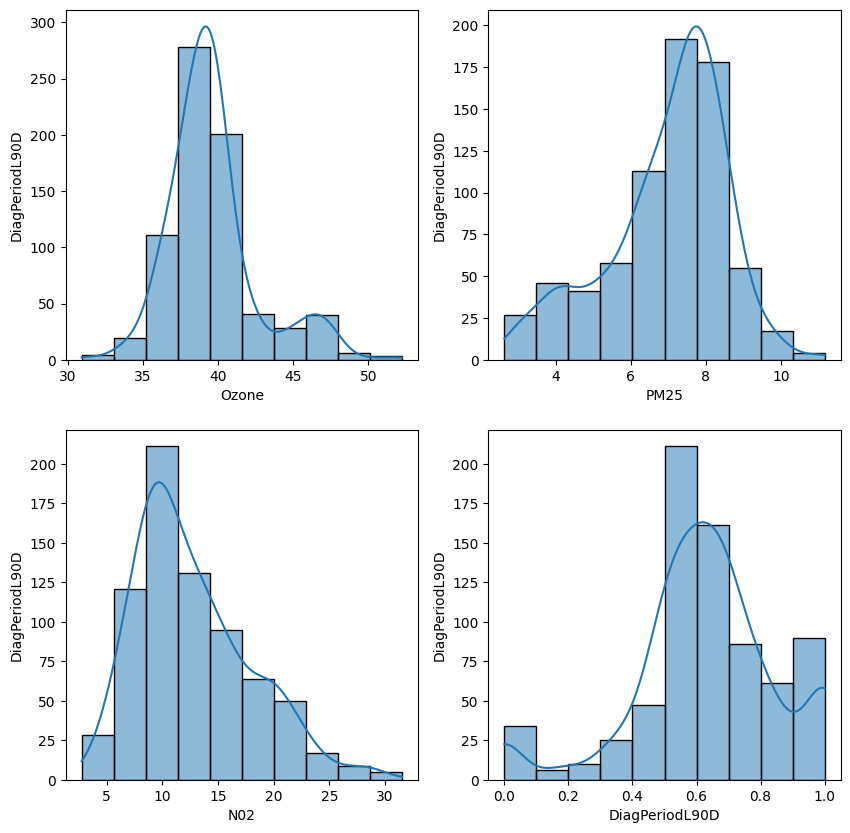

In [ ]:
# plot "DiagPeriodL90D"
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 10))
for i, col in enumerate(env_demo_clean.iloc[:,-4:]):
    plt.subplot(2, 2, i+1)
    sns.histplot(env_demo_clean[col], bins = 10, kde=True)
    plt.xlabel(col)
    plt.ylabel('DiagPeriodL90D')

<Axes: ylabel='DiagPeriodL90D'>

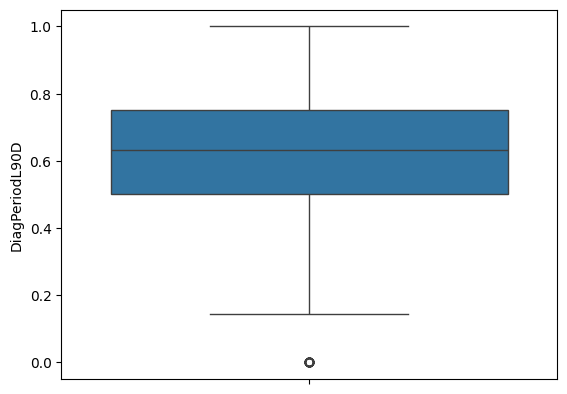

In [ ]:
sns.boxplot(data=env_demo_clean.iloc[:,-1])

<Axes: >

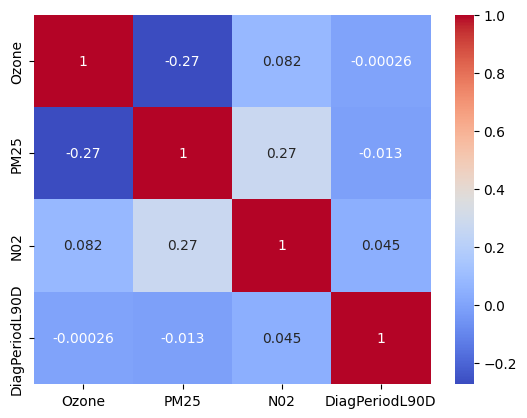

In [ ]:
sns.heatmap(env_demo_clean.iloc[:,-4:].corr(), annot=True, cmap='coolwarm')

In [283]:
import geopandas as gpd
import matplotlib.pyplot as plt

# Load geographic data (ZIP code prefix polygons)
geo_data = gpd.read_file(base_path + "/tl_2020_us_zcta520/tl_2020_us_zcta520.shp")
geo_data['zip_prefix'] = geo_data['ZCTA5CE20'].astype(str).str[:3]
geo_data['zip_prefix'] = geo_data['zip_prefix'].astype(int)

# Merge with my data
merged_data = geo_data.merge(env_demo_clean, left_on= 'zip_prefix', right_on='patient_zip3', how='left')
# merged_data

# Plot the map
fig, axes = plt.subplots(2, 1, figsize=(12, 10))
axes[0] = merged_data.plot(column='DiagPeriodL90D', cmap='viridis', legend=True, ax=axes[0])
axes[0].set_title('DiagPeriodL90D')
axes[0].axis('off')
axes[1] = merged_data.plot(column='health_uninsured', cmap='viridis', legend=True, ax=axes[1])
axes[1].set_title('health_uninsured')
axes[1].axis('off')


NameError: name 'env_demo_clean' is not defined

Mean Squared Error: 0.06123478651063384
R-squared: -0.011595526720210136
[0.67669953 0.67859929 0.56874598 0.71085567 0.64251456 0.6217059
 0.66393769 0.7425599  0.61253533 0.58489349] 703    0.272727
33     1.000000
300    0.750000
456    0.642857
633    1.000000
557    0.789474
39     0.440000
356    0.833333
559    0.500000
514    0.428571
Name: DiagPeriodL90D, dtype: float64


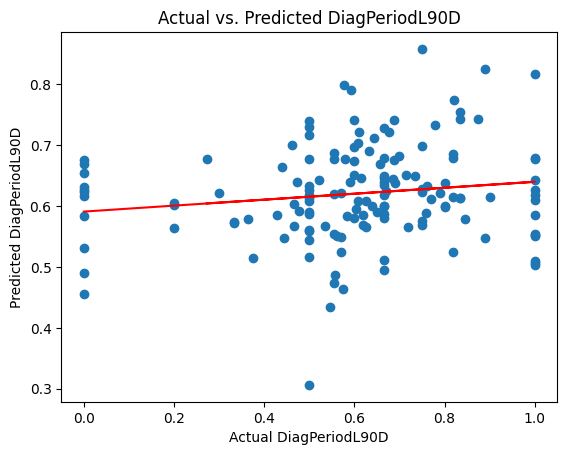

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

X = env_demo_clean.drop(columns=['DiagPeriodL90D'])
y = env_demo_clean['DiagPeriodL90D']

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=42)

# Create a linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")
print(y_pred[:10], y_test[:10])

# Plot the scatter plot
plt.scatter(y_test, y_pred)
plt.xlabel("Actual DiagPeriodL90D")
plt.ylabel("Predicted DiagPeriodL90D")
plt.title("Actual vs. Predicted DiagPeriodL90D")

# Add the trendline
z = np.polyfit(y_test, y_pred, 1)
p = np.poly1d(z)
plt.plot(y_test,p(y_test), color='red')

plt.show()

In [ ]:
# Quantify collinearity using measures like the Variance Inflation Factor (VIF):

# High VIF (>5 or 10 depending on the context) suggests multicollinearity.
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif = pd.DataFrame()
vif['Variable'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
display(vif) # super correlated

,Variable,VIF
0,patient_zip3,1.936752e+01
1,population,3.354736e+02
2,density,5.341383e+00
3,age_median,3.822471e+03
4,age_under_10,2.087791e+05
5,age_10_to_19,2.950467e+05
6,age_20s,2.858449e+05
7,age_30s,2.506636e+05
8,age_40s,2.341903e+05
9,age_50s,3.282177e+05


Total variance explained with first 10 PC: 0.764089491814191


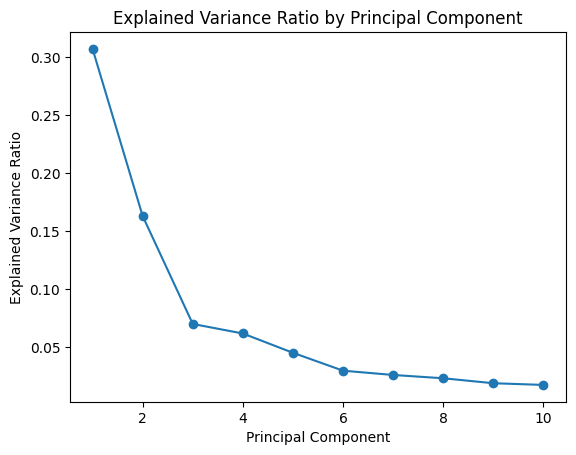

In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply PCA
pca = PCA(n_components=10)
X_pca = pca.fit_transform(X_scaled)

# Check on variance
explained_variance = pca.explained_variance_ratio_
print(f"Total variance explained with first 10 PC: {explained_variance.sum()}")

# Plot the explained_variance
plt.plot(range(1, len(explained_variance) + 1), explained_variance, 'o-')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.title('Explained Variance Ratio by Principal Component')
plt.show()


In [ ]:
X_pca_PC6 = pd.DataFrame(X_pca, columns=['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9', 'PC10'])
env_demo_pca = pd.concat([X_pca_PC6, env_demo_clean['DiagPeriodL90D']], axis=1)
env_demo_pca.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,DiagPeriodL90D
0,10.890850,-3.052669,6.533548,-3.757207,1.829594,4.571812,-1.021051,-4.403428,-0.946496,4.341458,1.000000
1,6.805928,0.427250,2.763942,-0.778573,3.194681,-1.138959,0.147709,1.521862,-0.170138,-0.730265,0.600000
2,6.288081,11.578180,3.108302,2.242275,4.236973,-0.485294,4.590033,-2.024314,-0.820170,-1.982592,0.575221
3,9.452495,-3.777125,4.687063,-1.011612,0.763458,-0.480601,-3.347124,2.214587,0.218616,-2.314631,0.727273
4,9.215988,-0.771322,3.130950,-0.434023,1.719192,0.394312,-0.830746,0.024679,-0.020703,-1.106904,0.400000


Mean Squared Error: 0.06008555990800189
R-squared: 0.007389637704401042
[0.66572382 0.63548104 0.61087246 0.64005385 0.68531115 0.62338364
 0.62030777 0.63915366 0.61657728 0.6047542 ] 
 703    0.272727
33     1.000000
300    0.750000
456    0.642857
633    1.000000
557    0.789474
39     0.440000
356    0.833333
559    0.500000
514    0.428571
Name: DiagPeriodL90D, dtype: float64


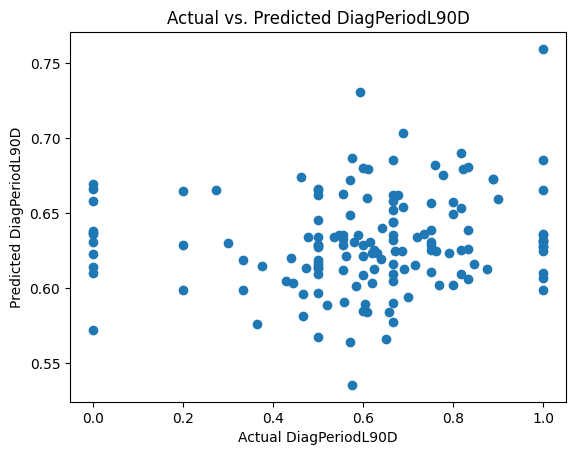

In [ ]:
# Build linear regression on env_demo_pca
X = env_demo_pca.drop(columns=['DiagPeriodL90D'])
y = env_demo_pca['DiagPeriodL90D']

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=42)

# Create a linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")
print(y_pred[:10], '\n',y_test[:10])

# Plot the scatter plot
plt.scatter(y_test, y_pred)
plt.xlabel("Actual DiagPeriodL90D")
plt.ylabel("Predicted DiagPeriodL90D")
plt.title("Actual vs. Predicted DiagPeriodL90D")
plt.show()

In [ ]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(random_state=123)
rf.fit(X_train, y_train)
rf.score(X_test, y_test)

0.003455803109714939

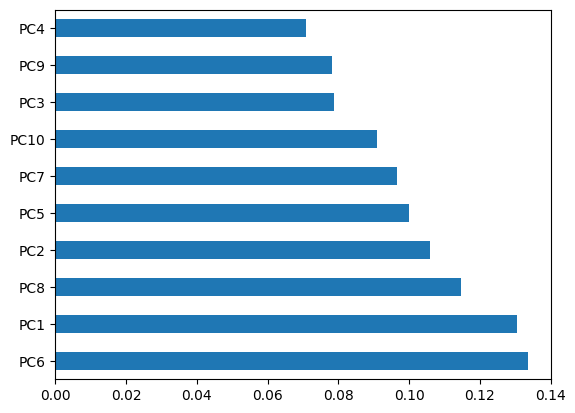

In [ ]:
feature_imp = pd.Series(rf.feature_importances_, index=X.columns)
feature_imp.nlargest(10).plot(kind='barh')
plt.show()


### Subset only environmental features

Total variance explained with first 10 PC: 0.809252682138371


Text(0.5, 1.0, 'PCA Scatter Plot')

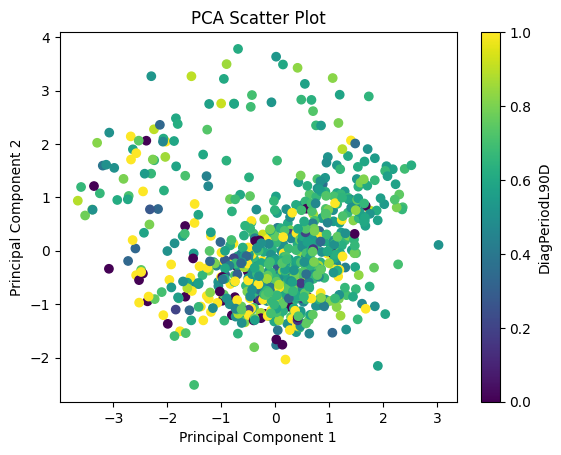

In [ ]:
env = env_demo_clean.iloc[:,-4:]

X = env.drop(columns=['DiagPeriodL90D'])
y = env['DiagPeriodL90D']

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply PCA

env_pca = PCA(n_components=2, random_state=123)
X_pca = env_pca.fit_transform(X_scaled)

# Check on variance
explained_variance = env_pca.explained_variance_ratio_
print(f"Total variance explained with first 10 PC: {explained_variance.sum()}")

plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(label='DiagPeriodL90D')
plt.title('PCA Scatter Plot')



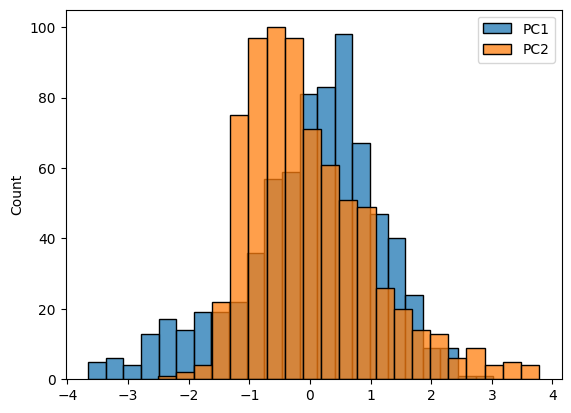

In [ ]:
sns.histplot(X_pca[:,0], label = "PC1")
sns.histplot(X_pca[:,1], label = "PC2")
plt.legend()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_pca,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=123)


In [ ]:
# Random forest
rf_env = RandomForestRegressor(n_estimators = 500, random_state=123)
rf_env.fit(X_train, y_train)
rf_env.score(X_test, y_test)

-0.018636816558861735

In [ ]:
from xgboost import XGBRegressor

model = XGBRegressor(objective="reg:squarederror")
model.fit(X_train, y_train)

predictions = model.predict(X_test).clip(0, 1)  # Ensure bounds

r2_score(y_test, predictions)

-0.2555948834304269

## Grid Search

In [262]:
optuna.logging.set_verbosity(optuna.logging.INFO)

In [263]:
# Model Building and Evaluation
# Define LightGBM model with Optuna hyperparameter optimization
X = train_division_dummy.drop(columns=['DiagPeriodL90D'])  # Features
y = train_division_dummy['DiagPeriodL90D']
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
feature_names = X_train.columns

def objective_lgbm(trial):
    # Define the hyperparameter search space
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 200, 300),
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.1, log=True),
        'max_depth': trial.suggest_int('max_depth', -1, 10),  # -1 for no limit
        'num_leaves': trial.suggest_int('num_leaves', 20, 150),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 50),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 10.0, log=True),  # L1 regularization
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 10.0, log=True),  # L2 regularization
        'random_state': 42
    }

    # Instantiate the LightGBM classifier
    lgbm_model = LGBMClassifier(**params)

    # Define the pipeline
    clf = Pipeline(steps=[('classifier', lgbm_model)])

    # Perform cross-validation and compute the mean AUC
    auc_scores = cross_val_score(clf, X_train, y_train, cv=5, scoring='roc_auc', n_jobs=-1)
    mean_auc = np.mean(auc_scores)

    return mean_auc

In [264]:
# Create and run the Optuna study for LightGBM
study_lgbm = optuna.create_study(direction='maximize')
study_lgbm.optimize(objective_lgbm, n_trials=70)

# Get the best parameters for LightGBM
best_params_lgbm = study_lgbm.best_params

[I 2024-12-08 22:07:41,369] A new study created in memory with name: no-name-c8b96214-cd18-4cb7-873b-8c3d49ffd607
[I 2024-12-08 22:07:46,702] Trial 0 finished with value: 0.7483530640194915 and parameters: {'n_estimators': 205, 'learning_rate': 0.015727449586901438, 'max_depth': 1, 'num_leaves': 119, 'min_child_samples': 5, 'subsample': 0.8904397682658463, 'colsample_bytree': 0.8763882757205961, 'reg_alpha': 1.6941807740139002e-05, 'reg_lambda': 0.005329858037576869}. Best is trial 0 with value: 0.7483530640194915.
[I 2024-12-08 22:07:49,401] Trial 1 finished with value: 0.8024093649922002 and parameters: {'n_estimators': 264, 'learning_rate': 0.08972759901438976, 'max_depth': 4, 'num_leaves': 85, 'min_child_samples': 9, 'subsample': 0.6770494428888327, 'colsample_bytree': 0.7767658502524607, 'reg_alpha': 6.6291445596987295e-06, 'reg_lambda': 0.00014234164939546615}. Best is trial 1 with value: 0.8024093649922002.
[I 2024-12-08 22:07:57,473] Trial 2 finished with value: 0.7994607914646

In [265]:
lgbm_model_tuned = LGBMClassifier(**best_params_lgbm, random_state=42)
clf_lgbm = Pipeline(steps=[('classifier', lgbm_model_tuned)])
clf_lgbm.fit(X_train, y_train)
cv_scores_lgbm_tuned = cross_val_score(clf_lgbm, X_train, y_train, cv=5, scoring='roc_auc')
mean_score_lgbm_tuned = cv_scores_lgbm_tuned.mean()
std_score_lgbm_tuned = cv_scores_lgbm_tuned.std()
optuna.visualization.plot_optimization_history(study_lgbm)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 6426, number of negative: 3895
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002289 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2217
[LightGBM] [Info] Number of data points in the train set: 10321, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.622614 -> initscore=0.500659
[LightGBM] [Info] Start training from score 0.500659
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

In [266]:
print("mean CV ROC-AUC - Light GBM", mean_score_lgbm_tuned, "std CV ROC-AUC - Light GBM", std_score_lgbm_tuned)

mean CV ROC-AUC - Light GBM 0.8067319837549958 std CV ROC-AUC - Light GBM 0.008853215361622327


In [267]:
best_params_lgbm

{'n_estimators': 284,
 'learning_rate': 0.014760927793941383,
 'max_depth': 6,
 'num_leaves': 61,
 'min_child_samples': 8,
 'subsample': 0.682309325318458,
 'colsample_bytree': 0.6255912045873175,
 'reg_alpha': 1.2210950919261463,
 'reg_lambda': 0.5026918764778678}

In [268]:
# Build the pandas df for above result
pd.DataFrame([best_params_lgbm]).T

,0
n_estimators,284.000000
learning_rate,0.014761
max_depth,6.000000
num_leaves,61.000000
min_child_samples,8.000000
subsample,0.682309
colsample_bytree,0.625591
reg_alpha,1.221095
reg_lambda,0.502692


In [269]:
optuna.visualization.plot_param_importances(study_lgbm).show()

In [ ]:
optuna.visualization.plot_optimization_history(study_lgbm)

In [270]:
def objective_lasso_logistic(trial):
    # Define the hyperparameter search space
    params = {
        'C': trial.suggest_float('C', 1e-3, 1e2, log=True),  # Inverse of regularization strength
        'penalty': 'l1',  # Lasso regularization
        'solver': 'liblinear',  # Solver that supports L1 penalty
        'random_state': 42
    }

    # Create a Logistic Regression model with Lasso (L1) regularization
    lasso_model = LogisticRegression(**params)

    # Define the pipeline
    clf = Pipeline(steps=[('scaler', scaler),
                           ('classifier', lasso_model)])

    # Perform cross-validation and compute the mean AUC
    auc_scores = cross_val_score(clf, X_train, y_train, cv=5, scoring='roc_auc', n_jobs=-1)
    mean_auc = np.mean(auc_scores)

    return mean_auc

In [271]:
# Create and run the Optuna study for LASSO Logistic
study_lasso = optuna.create_study(direction='maximize')
study_lasso.optimize(objective_lasso_logistic, n_trials=100)

# Get the best parameters for LASSO Logistic
best_params_lasso = study_lasso.best_params

[I 2024-12-08 22:59:02,733] A new study created in memory with name: no-name-eee55705-2808-4ec4-9133-dfabed744858
[I 2024-12-08 22:59:11,713] Trial 0 finished with value: 0.7601543666460037 and parameters: {'C': 0.33550819255568926}. Best is trial 0 with value: 0.7601543666460037.
[I 2024-12-08 22:59:14,475] Trial 1 finished with value: 0.760334819256433 and parameters: {'C': 0.150045713613734}. Best is trial 1 with value: 0.760334819256433.
[I 2024-12-08 22:59:16,016] Trial 2 finished with value: 0.759378279413425 and parameters: {'C': 0.027382290744474905}. Best is trial 1 with value: 0.760334819256433.
[I 2024-12-08 22:59:23,549] Trial 3 finished with value: 0.7598727260726165 and parameters: {'C': 26.22705516290443}. Best is trial 1 with value: 0.760334819256433.
[I 2024-12-08 22:59:24,896] Trial 4 finished with value: 0.75664248866716 and parameters: {'C': 0.01420109486191064}. Best is trial 1 with value: 0.760334819256433.
[I 2024-12-08 22:59:29,078] Trial 5 finished with value: 

In [272]:
lasso_model_tuned = LogisticRegression(**best_params_lasso, penalty='l1', solver='liblinear', random_state=42)
clf_lasso = Pipeline(steps=[('classifier', lasso_model_tuned)])
clf_lasso.fit(X_train, y_train)
cv_scores_lasso_tuned = cross_val_score(clf_lasso, X_train, y_train, cv=5, scoring='roc_auc',n_jobs=-1)
mean_score_lasso_tuned = cv_scores_lasso_tuned.mean()
std_score_lasso_tuned = cv_scores_lasso_tuned.std()
mean_score_lasso_tuned

0.7552320145441179

In [273]:
print("mean CV ROC-AUC - LASSO", mean_score_lasso_tuned, "std CV ROC-AUC - LASSO", std_score_lasso_tuned)

mean CV ROC-AUC - LASSO 0.7552320145441179 std CV ROC-AUC - LASSO 0.010328742764919482


In [274]:
best_params_lasso

{'C': 0.06990369835109744}

In [275]:
optuna.visualization.plot_optimization_history(study_lasso)

In [276]:
def objective_rf(trial):
    # Define the hyperparameter search space
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),  # Number of trees
        'max_depth': trial.suggest_int('max_depth', 3, 30, step=3),  # Maximum depth of trees
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),  # Minimum samples required to split an internal node
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 20),  # Minimum samples required to be a leaf node
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2', None]),  # Number of features to consider at each split
        'bootstrap': trial.suggest_categorical('bootstrap', [True, False]),  # Whether bootstrap samples are used
        'random_state': 42
    }

    # Create the Random Forest model
    rf_model = RandomForestClassifier(**params)

    # Define the pipeline
    clf = Pipeline(steps=[('classifier', rf_model)])

    # Perform cross-validation and compute the mean AUC
    auc_scores = cross_val_score(clf, X_train, y_train, cv=5, scoring='roc_auc', n_jobs=-1)
    mean_auc = np.mean(auc_scores)

    return mean_auc

In [277]:
# Create and run the Optuna study for RF
study_rf = optuna.create_study(direction='maximize')
study_rf.optimize(objective_rf, n_trials=50)

# Get the best parameters for rf
best_params_rf = study_rf.best_params

[I 2024-12-08 23:08:01,471] A new study created in memory with name: no-name-97a4137b-7cc2-4a8e-bd51-03eecf915107
[I 2024-12-08 23:08:21,052] Trial 0 finished with value: 0.7968558053544547 and parameters: {'n_estimators': 457, 'max_depth': 9, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'bootstrap': True}. Best is trial 0 with value: 0.7968558053544547.
[I 2024-12-08 23:08:29,863] Trial 1 finished with value: 0.8004294090953359 and parameters: {'n_estimators': 222, 'max_depth': 18, 'min_samples_split': 4, 'min_samples_leaf': 12, 'max_features': 'log2', 'bootstrap': True}. Best is trial 1 with value: 0.8004294090953359.
[I 2024-12-08 23:10:34,824] Trial 2 finished with value: 0.7785927508306908 and parameters: {'n_estimators': 407, 'max_depth': 9, 'min_samples_split': 3, 'min_samples_leaf': 20, 'max_features': None, 'bootstrap': False}. Best is trial 1 with value: 0.8004294090953359.
[I 2024-12-08 23:10:58,080] Trial 3 finished with value: 0.7966408665189281 a

In [278]:
best_params_rf

{'n_estimators': 326,
 'max_depth': 21,
 'min_samples_split': 19,
 'min_samples_leaf': 14,
 'max_features': 'sqrt',
 'bootstrap': True}

In [279]:
pd.DataFrame([best_params_rf]).T

,0
n_estimators,326
max_depth,21
min_samples_split,19
min_samples_leaf,14
max_features,sqrt
bootstrap,True


In [280]:
rf_model_tuned = RandomForestClassifier(**best_params_rf,random_state=42)
clf_rf = Pipeline(steps=[('classifier', rf_model_tuned)])
cv_scores_rf_tuned = cross_val_score(clf_rf, X_train, y_train, cv=5, scoring='roc_auc')
mean_score_rf_tuned = cv_scores_rf_tuned.mean()
std_score_rf_tuned = cv_scores_rf_tuned.std()
optuna.visualization.plot_optimization_history(study_rf)
print("mean CV ROC-AUC - RF", mean_score_rf_tuned, "std CV ROC-AUC - RF", std_score_rf_tuned)

mean CV ROC-AUC - RF 0.8018276721289632 std CV ROC-AUC - RF 0.009168918917144072


In [281]:
optuna.visualization.plot_optimization_history(study_rf)

In [282]:
optuna.visualization.plot_param_importances(study_rf).show()